In [1]:
import networkx as nx
import random
from collections import deque, defaultdict

In [2]:

def generate_tree(N, K):
    
    T = nx.DiGraph()
    C = defaultdict(int)
    
    for i in range(N):
        T.add_node(i)
    
    for i in range(1, N):
        p = None
        while True:
            p = random.randint(0, i - 1)
            if C[p] < K:
                break
        T.add_edge(p, i)
        C[p] += 1
    
    return T


In [3]:

class DLNode:
    def __init__(self, v, nxt, prv):
        self.v = v
        self.next = nxt
        self.back = prv

class DList:
    
    MXNODES = 10000000
    nodes = [None for i in range(MXNODES)]
    cnt = 0
    
    def __init__(self, arr):
        
        self.first = None
        self.last  = None
        
        for v in arr:
            DList.nodes[DList.cnt] = DLNode(v, None, self.last)
            if self.last:
                DList.nodes[self.last].next = DList.cnt
            self.last = DList.cnt; DList.cnt += 1
            if not self.first:
                self.first = self.last
    
    def reset(self):
        DList.cnt = 0
        DList.nodes = []
    
    def append_right(self, v):
        
        DList.nodes[DList.cnt] = DLNode(v, None, self.last)
        if self.first:
            DList.nodes[self.last].next = DList.cnt
        else:
            self.first = DList.cnt
        self.last = DList.cnt; DList.cnt += 1
        
    def append_left(self, v):
        
        DList.nodes[DList.cnt] = DLNode(v, self.first, None)
        if self.first:
            DList.nodes[self.first].back = DList.cnt
        else:
            self.last = DList.cnt
        self.first = DList.cnt; DList.cnt += 1
        
    def extend_right(self, first, last):
        
        DList.nodes[self.last].next = first
        DList.nodes[first].back = self.last
        self.last = last
            
    def extend_left(self, first, last):
        
        DList.nodes[self.first].back = last
        DList.nodes[last].next = self.first
        self.first = first
        
    def remove_right(self, pos):
        
        self.last = pos
        DList.nodes[self.last].next = None
            
    def remove_left(self, pos):
        
        self.first = pos
        DList.nodes[self.first].back = None
        
    def remove_pos(self, pos):
        
        if self.first == pos:
            self.first = DList.nodes[pos].next
        if self.last == pos:
            self.last = DList.nodes[pos].back
        l = DList.nodes[pos].back; r = DList.nodes[pos].next
        if l is not None:
            DList.nodes[l].next = r
        if r is not None:
            DList.nodes[r].back = l
            
    def pop_left(self):
        
        if self.first is not None:
            self.first = DList.nodes[self.first].next
        if self.first is not None:
            DList.nodes[self.first].back = None
    
    def pop_right(self):
        
        if self.last is not None:
            self.last = DList.nodes[self.last].back
        if self.last is not None:
            DList.nodes[self.last].next = None
        

In [4]:

def get_optimal_function(T, debug=False):
    
    order = [u for u in nx.topological_sort(T)][::-1]
    S = [DList([]) for i in range(N)]
    P = [0 for i in range(N)]

    F = {e: None for e in T.edges()}

    for u in order:  ## Generamos la extensión en orden buttom-up

        if debug:
            print(f"Node {u}")

        children = [v for v in T.successors(u)]

        if debug:
            print(f"children: {children}")
        if len(children) == 0:
            continue

        if len(children) == 1:  ## En caso de un sólo hijo

            v = children[0]

            # Buscamos el menor valor libre
            i = S[v].first
            free = 1
            while i:
                if DList.nodes[i].v > free:
                    break
                free = DList.nodes[i].v + 1
                i = DList.nodes[i].next

            S[u].append_right(free)

            F[(u, v)] = free

            if i is not None:  # Sólo nos quedamos con los valores expuestos
                S[u].extend_right(i, S[v].last)
            continue

        for v in children:
            P[v] = S[v].first

        # Buscamos l2 iterando coordinadamente

        l2 = -1; active = set(children); last_erased = None
        while len(active) > 1:
            l2 += 1

            to_erase = []
            for v in active:
                while P[v] is not None and DList.nodes[P[v]].v <= l2:
                    P[v] = DList.nodes[P[v]].next
                if P[v] is None:
                    to_erase.append(v)

            for v in to_erase:
                last_erased = v
                active.remove(v)

        i1 = None  # hijo de secuencia más grande
        if len(active) == 0:
            i1 = last_erased
        else:
            i1 = next(iter(active))

        children = [i1] + [ch for ch in children if ch != i1]

        # Generamos las listas ordenadas L[1:l2 + 1]

        L = [DList(children.copy())] + [None for i in range(l2)]
        L_ = {v: [] for v in children}

        it = L[0].first
        while it is not None:
            v = DList.nodes[it].v
            L_[v].append(it)
            it = DList.nodes[it].next

        last = {v: 0 for v in children}
        M = [{v: 0 for v in children}] + [None for i in range(l2)]
        C = [len(children)] + [0 for i in range(l2)]

        for v in children:
            P[v] = S[v].first

        for i in range(1, l2 + 1):    
            to_erase = set(); has_i = set()
            it = L[i - 1].first
            while it is not None:
                v = DList.nodes[it].v
                while P[v] is not None and DList.nodes[P[v]].v <= i:
                    if DList.nodes[P[v]].v == i:
                        has_i.add(v)
                    P[v] = DList.nodes[P[v]].next
                if P[v] is None:
                    to_erase.add(v)
                it = DList.nodes[it].next

            L_p = []; L_m = []
            it = L[i - 1].first
            while it is not None:
                v = DList.nodes[it].v
                if v in has_i:
                    L_p.append(v)
                elif v not in to_erase:
                    L_m.append(v)
                it = DList.nodes[it].next

            C[i] = 0
            L[i] = DList(L_p + L_m)
            it = L[i].first
            while it is not None:
                v = DList.nodes[it].v
                L_[v].append(it)
                it = DList.nodes[it].next
                C[i] += 1

            M[i] = {v: 0 for v in children}
            it = L[i].first
            while it is not None:
                v = DList.nodes[it].v
                M[i][v] = last[v]
                if v in has_i:
                    last[v] = i
                it = DList.nodes[it].next

        for v in children:
            P[v] = S[v].first
            nxt = None if P[v] is None else DList.nodes[P[v]].next
            while (P[v] is not None) and (nxt is not None) and DList.nodes[nxt].v <= l2:
                P[v] = nxt
                nxt = None if P[v] is None else DList.nodes[P[v]].next

        if debug:
            print(f"l2: {l2}")

        U = deque([])

        G = {v: 0 for v in children}

        p_i1 = P[i1]
        if (p_i1 is not None) and DList.nodes[p_i1].v == l2:
            p_i1 = DList.nodes[p_i1].next

        curr = l2; lst = l2; last_i1 = l2; cnt_0 = len(children)
        active = set()
        for v in children:
            if P[v] is not None:
                active.add(v)

        while curr > 0 or cnt_0 > 0:

            cnt = 0
            for v in active:
                if DList.nodes[P[v]].v == curr:
                    cnt += 1

            if debug:
                print(f"curr: {curr}, cnt: {cnt}, cnt_0: {cnt_0}")

            if cnt == 0 and lst > curr:
                for x in range(max(curr, 1), lst):
                    U.append(x)
            lst = curr
            if cnt <= 1 and curr != 0:
                to_remove = []
                for v in active:
                    if DList.nodes[P[v]].v == curr:
                        P[v] = DList.nodes[P[v]].back
                        if P[v] is None:
                            to_remove.append(v)
                for v in to_remove:
                    active.remove(v)
                curr -= 1
                continue

            w = None
            if U:
                w = U.pop()
            else:
                while p_i1 is not None:
                    if last_i1 + 1 < DList.nodes[p_i1].v:
                        break
                    last_i1 = DList.nodes[p_i1].v
                    p_i1 = DList.nodes[p_i1].next
                w = last_i1 + 1
                last_i1 += 1

            best_j = None
            if w <= l2:      
                flag = False
                if L[w].first is not None:
                    m = M[w][DList.nodes[L[w].first].v]
                    if C[w] == C[m]:
                        best_j = DList.nodes[L[w].first].v
                    elif C[m + 1] == C[w]:
                        best_j = DList.nodes[L[m].first].v
                    else:
                        flag = True

                if L[w].first is None or flag == True:
                    for i in range(w):
                        if C[i] > C[w] and C[i + 1] == C[w]:
                            best_j = DList.nodes[L[i].first].v
            else:
                if S[i1].first is not None and DList.nodes[S[i1].first].v < w:
                    best_j = i1
                else:
                    flag = False
                    if L[l2].first is not None:
                        m = M[l2][DList.nodes[L[l2].first].v]
                        if C[l2] == C[m]:
                            best_j = DList.nodes[L[l2].first].v
                        elif C[m + 1] == C[l2]:
                            best_j = DList.nodes[L[m].first].v
                        else:
                            flag = True

                    if L[l2].first is None or flag == True:
                        for i in range(l2):
                            if C[i] > C[l2] and C[i + 1] == C[l2]:
                                best_j = DList.nodes[L[i].first].v

            if debug:
                print(f"best_j: {best_j}, w: {w}, active: {len(active)}")

            to_add = deque([])
            while P[best_j] is not None and DList.nodes[P[best_j]].v <= w:
                v_ = DList.nodes[P[best_j]].v
                if v_ > curr:
                    to_add.append(v_)
                P[best_j] = DList.nodes[P[best_j]].next
            while to_add:
                U.append(to_add.pop())

            mxx = None
            if P[best_j] is None:
                if best_j != i1:
                    for i in range(last[best_j] + 1):
                        C[i] -= 1
                else:
                    for i in range(l2 + 1):
                        C[i] -= 1
                S[best_j] = DList([])
                mxx = l2
            else:
                S[best_j].remove_left(P[best_j])
                mxx = min(l2, DList.nodes[P[best_j]].v - 1)

            ll = len(L_[best_j]); mxx = min(mxx, ll - 1)
            while mxx >= 0 and L_[best_j][mxx] != -1:
                L[mxx].remove_pos(L_[best_j][mxx])
                L_[best_j][mxx] = -1
                M[mxx][best_j] = -1
                mxx -= 1

            if G[best_j] == 0:
                cnt_0 -= 1
            G[best_j] = w
            if best_j in active:
                active.remove(best_j)

        for k, v in G.items():
            F[(u, k)] = v

        for v in children:
            S[v].append_left(G[v])

        active = set(children)
        while len(active) > 1:

            id_ = None; mn = 1e9
            for v in active:
                if DList.nodes[S[v].first].v < mn:
                    mn = DList.nodes[S[v].first].v
                    id_ = v

            S[u].append_right(mn)
            S[id_].pop_left()
            if S[id_].first is None:
                active.remove(id_)

        i1 = next(iter(active))
        S[u].extend_right(S[i1].first, S[i1].last)
        
    print("Optimal Steps:", max(F.values()))
        
    return F


In [5]:
from time import time

times = []
for N in [10, 100, 1000, 10000, 100000]:
    T = generate_tree(N, 10)
    st = time()
    F = get_optimal_function(T)
    et = time()
    print(f"Elapsed {et - st}s.\n")
    times.append(et - st)

Optimal Steps: 4
Elapsed 0.0008244514465332031s.

Optimal Steps: 10
Elapsed 0.003699064254760742s.

Optimal Steps: 15
Elapsed 0.16208291053771973s.

Optimal Steps: 19
Elapsed 0.48342251777648926s.

Optimal Steps: 25
Elapsed 4.879442930221558s.



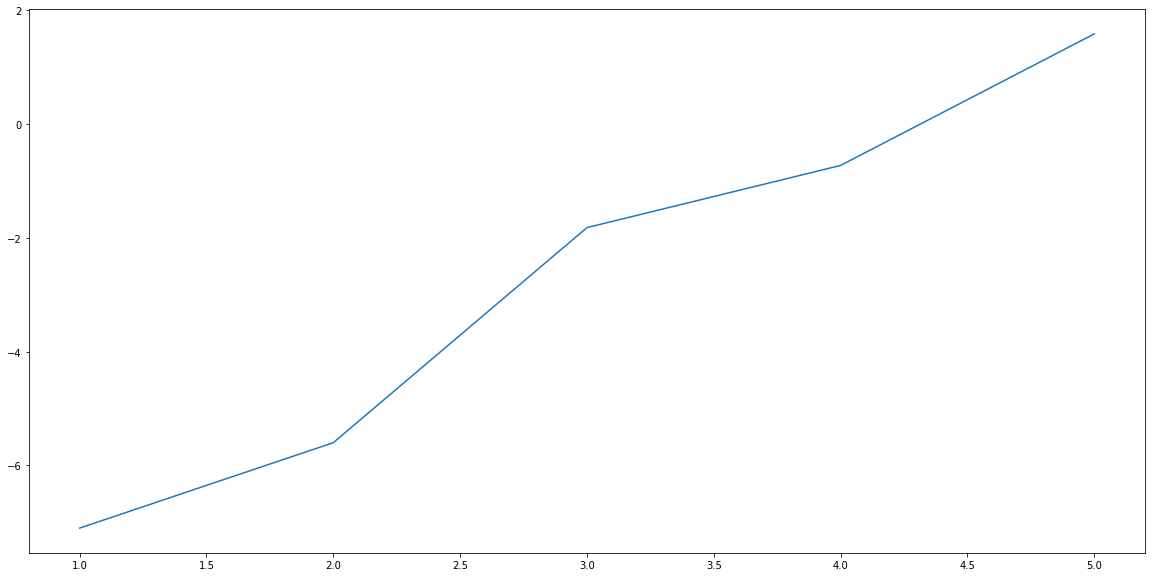

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))
plt.plot(range(1, 6), [np.log(t) for t in times])

In [124]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
        
###################################################################################################

        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[dest], id_[origin])
    
N = l

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [103]:
st = time()
F = get_optimal_function(T)
et = time()

print(et - st)

Optimal Steps: 10
14.140000104904175


In [9]:

def get_optimal_K_function(T, K, debug=False):
    
    order = [u for u in nx.topological_sort(T)][::-1]
    S = [DList([]) for i in range(N)]
    P = [0 for i in range(N)]

    F = {e: None for e in T.edges()}

    for u in order:  ## Generamos la extensión en orden buttom-up

        if debug:
            print(f"Node {u}")

        children = [v for v in T.successors(u)]

        if debug:
            print(f"children: {children}")
        if len(children) == 0:
            continue

        if len(children) == 1:  ## En caso de un sólo hijo

            v = children[0]

            # Buscamos el menor valor libre
            i = S[v].first
            free = 1
            while i:
                if DList.nodes[i].v[0] > free:
                    break
                elif DList.nodes[i].v[1] < K:
                    break
                free = DList.nodes[i].v[0] + 1
                i = DList.nodes[i].next

            if i and DList.nodes[i].v[0] == free:
                DList.nodes[i].v = (DList.nodes[i].v[0], DList.nodes[i].v[1] + 1)
                S[u].append_right(DList.nodes[i].v)
                i = DList.nodes[i].next
            else:
                S[u].append_right((free, 1))

            F[(u, v)] = free
            F[(v, u)] = free

            if i is not None:  # Sólo nos quedamos con los valores expuestos
                S[u].extend_right(i, S[v].last)
            continue

        for v in children:
            P[v] = S[v].first

        # Buscamos l2 iterando coordinadamente

        l2 = -1; active = set(children); last_erased = None
        while len(active) > 1:
            l2 += 1

            to_erase = []
            for v in active:
                while P[v] is not None and DList.nodes[P[v]].v[0] <= l2:
                    P[v] = DList.nodes[P[v]].next
                if P[v] is None:
                    to_erase.append(v)

            for v in to_erase:
                last_erased = v
                active.remove(v)

        i1 = None  # hijo de secuencia más grande
        if len(active) == 0:
            i1 = last_erased
        else:
            i1 = next(iter(active))

        children = [i1] + [ch for ch in children if ch != i1]

        # Generamos las listas ordenadas L[1:l2 + 1]

        L = [DList(children.copy())] + [None for i in range(l2)]
        L_ = {v: [] for v in children}

        it = L[0].first
        while it is not None:
            v = DList.nodes[it].v
            L_[v].append(it)
            it = DList.nodes[it].next

        last = {v: 0 for v in children}
        M = [{v: 0 for v in children}] + [None for i in range(l2)]
        C = [len(children)] + [0 for i in range(l2)]

        for v in children:
            P[v] = S[v].first
            
        for i in range(1, l2 + 1):    
            to_erase = set(); has_i = set()
            it = L[i - 1].first
            while it is not None:
                v = DList.nodes[it].v
                while P[v] is not None and DList.nodes[P[v]].v[0] <= i:
                    if DList.nodes[P[v]].v[0] == i:
                        has_i.add(v)
                    P[v] = DList.nodes[P[v]].next
                if P[v] is None:
                    to_erase.add(v)
                it = DList.nodes[it].next

            L_p = []; L_m = []
            it = L[i - 1].first
            while it is not None:
                v = DList.nodes[it].v
                if v in has_i:
                    L_p.append(v)
                elif v not in to_erase:
                    L_m.append(v)
                it = DList.nodes[it].next

            C[i] = 0
            L[i] = DList(L_p + L_m)
            it = L[i].first
            while it is not None:
                v = DList.nodes[it].v
                L_[v].append(it)
                it = DList.nodes[it].next
                C[i] += 1

            M[i] = {v: 0 for v in children}
            it = L[i].first
            while it is not None:
                v = DList.nodes[it].v
                M[i][v] = last[v]
                if v in has_i:
                    last[v] = i
                it = DList.nodes[it].next

        for v in children:
            P[v] = S[v].first
            nxt = None if P[v] is None else DList.nodes[P[v]].next
            while (P[v] is not None) and (nxt is not None) and DList.nodes[nxt].v[0] <= l2:
                P[v] = nxt
                nxt = None if P[v] is None else DList.nodes[P[v]].next

        if debug:
            print(f"l2: {l2}")

        U = deque([])

        G = {v: 0 for v in children}

        p_i1 = P[i1]
        while (p_i1 is not None) and DList.nodes[p_i1].v[0] <= l2:
            p_i1 = DList.nodes[p_i1].next

        curr = l2; lst = l2; last_i1 = l2 + 1; last_i1_cnt = 0; cnt_0 = len(children)
        active = set()
        for v in children:
            if P[v] is not None:
                active.add(v)

        while curr > 0 or cnt_0 > 0:

            cnt = 0
            for v in active:
                if DList.nodes[P[v]].v[0] == curr:
                    cnt += DList.nodes[P[v]].v[1]

            if debug:
                print(f"curr: {curr}, cnt: {cnt}, cnt_0: {cnt_0}")

            if cnt < K and lst > curr:
                for x in range(max(curr, 1), lst):
                    if x == curr:
                        U.append((x, K - cnt))
                    else:
                        U.append((x, K))
            lst = curr
            if cnt <= K and curr != 0:
                to_remove = []
                for v in active:
                    if DList.nodes[P[v]].v[0] == curr:
                        P[v] = DList.nodes[P[v]].back
                        if P[v] is None:
                            to_remove.append(v)
                for v in to_remove:
                    active.remove(v)
                curr -= 1
                continue

            w = None
            
            if U:
                w, cc = U.pop()
                if cc > 1:
                    U.append((w, cc - 1))
            else:
                while p_i1 is not None:
                    if last_i1 == DList.nodes[p_i1].v[0] and DList.nodes[p_i1].v[1] < K:
                        w = last_i1
                        last_i1_cnt += 1
                        if last_i1_cnt + DList.nodes[p_i1].v[1] == K:
                            last_i1 += 1
                            last_i1_cnt = 0
                            p_i1 = DList.nodes[p_i1].next
                        break
                    elif last_i1 == DList.nodes[p_i1].v[0] and DList.nodes[p_i1].v[1] == K:
                        last_i1 += 1
                        last_i1_cnt = 0
                        p_i1 = DList.nodes[p_i1].next
                    elif last_i1 < DList.nodes[p_i1].v[0] and last_i1_cnt < K:
                        w = last_i1
                        last_i1_cnt += 1
                        break
                    elif last_i1 < DList.nodes[p_i1].v[0] and last_i1_cnt == K:
                        last_i1 += 1
                        last_i1_cnt = 0
                if w is None:
                    w = last_i1
                    last_i1_cnt += 1
                    if last_i1_cnt == K:
                        last_i1 += 1
                        last_i1_cnt = 0
            
            best_j = None
            if w <= l2:      
                flag = False
                if L[w].first is not None:
                    m = M[w][DList.nodes[L[w].first].v]
                    if C[w] == C[m]:
                        best_j = DList.nodes[L[w].first].v
                    elif C[m + 1] == C[w]:
                        best_j = DList.nodes[L[m].first].v
                    else:
                        flag = True

                if L[w].first is None or flag == True:
                    for i in range(w):
                        if C[i] > C[w] and C[i + 1] == C[w]:
                            best_j = DList.nodes[L[i].first].v
            else:
                if S[i1].first is not None and DList.nodes[S[i1].first].v[0] < w:
                    best_j = i1
                else:
                    flag = False
                    if L[l2].first is not None:
                        m = M[l2][DList.nodes[L[l2].first].v]
                        if C[l2] == C[m]:
                            best_j = DList.nodes[L[l2].first].v
                        elif C[m + 1] == C[l2]:
                            best_j = DList.nodes[L[m].first].v
                        else:
                            flag = True

                    if L[l2].first is None or flag == True:
                        for i in range(l2):
                            if C[i] > C[l2] and C[i + 1] == C[l2]:
                                best_j = DList.nodes[L[i].first].v

            if debug:
                print(f"best_j: {best_j}, w: {w}, active: {len(active)}")
            
            to_add = deque([])
            if P[best_j] is None:
                P[best_j] = S[best_j].first
            while P[best_j] is not None and DList.nodes[P[best_j]].v[0] < w:
                v_ = DList.nodes[P[best_j]].v
                if v_[0] > curr:
                    to_add.append(v_)
                P[best_j] = DList.nodes[P[best_j]].next
            while to_add:
                U.append(to_add.pop())

            mxx = None
            if P[best_j] is None:
                if best_j != i1:
                    for i in range(last[best_j] + 1):
                        C[i] -= 1
                else:
                    for i in range(l2 + 1):
                        C[i] -= 1
                S[best_j] = DList([])
                mxx = l2
            else:
                S[best_j].remove_left(P[best_j])
                mxx = min(l2, DList.nodes[P[best_j]].v[0] - 1)

            ll = len(L_[best_j]); mxx = min(mxx, ll - 1)
            while mxx >= 0 and L_[best_j][mxx] != -1:
                L[mxx].remove_pos(L_[best_j][mxx])
                L_[best_j][mxx] = -1
                M[mxx][best_j] = -1
                mxx -= 1

            if G[best_j] == 0:
                cnt_0 -= 1
            G[best_j] = w
            if best_j in active:
                active.remove(best_j)

        for k, v in G.items():
            F[(u, k)] = v
            F[(k, u)] = v

        for v in children:
            if S[v].first is not None and DList.nodes[S[v].first].v[0] == G[v]:
                DList.nodes[S[v].first].v = (DList.nodes[S[v].first].v[0], DList.nodes[S[v].first].v[1] + 1)
            else:
                S[v].append_left((G[v], 1))

        active = set(children)
        while len(active) > 1:

            id_ = set(); mn = 1e9; cntt = 0
            for v in active:
                if debug:
                    print(v, DList.nodes[S[v].first].v)
                if DList.nodes[S[v].first].v[0] < mn:
                    mn = DList.nodes[S[v].first].v[0]
                    cntt = DList.nodes[S[v].first].v[1]
                    id_ = set([v])
                elif DList.nodes[S[v].first].v[0] == mn:
                    cntt += DList.nodes[S[v].first].v[1]
                    id_.add(v)
                    
            if debug:
                print(mn, cntt)

            S[u].append_right((mn, cntt))
            if cntt > K:
                print("FAILED", K, cntt)
                return 0
            for v in id_:
                S[v].pop_left()
                if S[v].first is None:
                    active.remove(v)

        if active:
            i1 = next(iter(active))
            S[u].extend_right(S[i1].first, S[i1].last)
        
    print("Optimal Steps:", max(F.values()))
        
    return F


In [10]:
from time import time

times = []
for N in [10, 100, 1000, 10000, 100000]:
    T = generate_tree(N, 10)
    st = time()
    F = get_optimal_K_function(T, 5)
    et = time()
    print(f"Elapsed {et - st}s.\n")
    times.append(et - st)

Optimal Steps: 2
Elapsed 0.0019686222076416016s.

Optimal Steps: 4
Elapsed 0.009325504302978516s.

Optimal Steps: 6
Elapsed 0.04089474678039551s.

Optimal Steps: 8
Elapsed 0.36998867988586426s.

Optimal Steps: 9
Elapsed 4.78046989440918s.



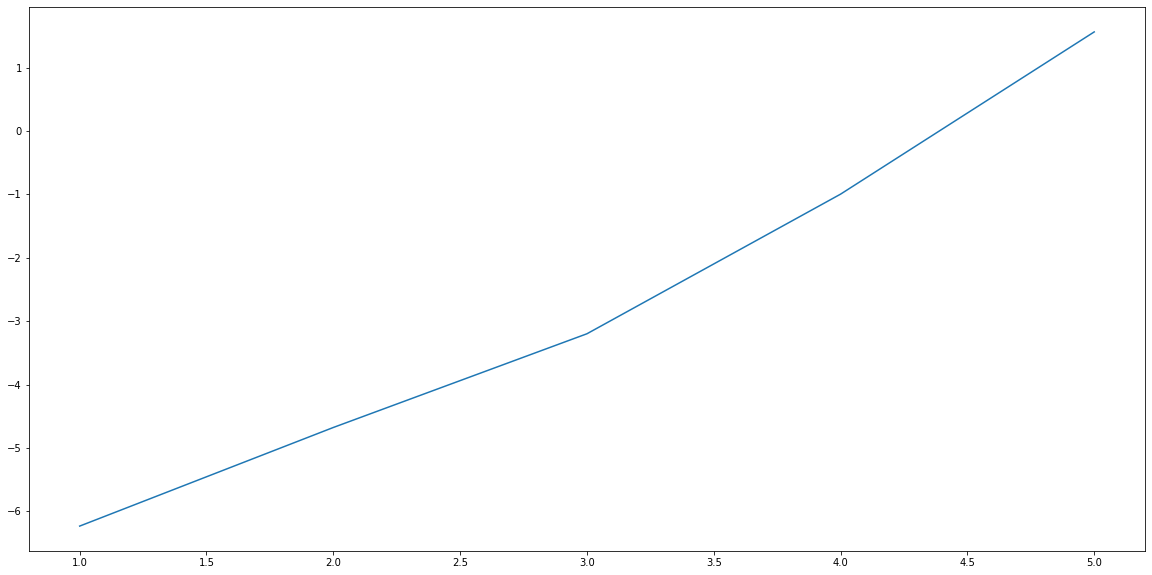

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))
plt.plot(range(1, 6), [np.log(t) for t in times])

In [13]:

def check_K_function(T, N, F, K):
    
    G = T.to_undirected()
    
    E = G.edges()
    
    for e in E:
        u1, u2 = e
        val = F[(u1, u2)]
        
#         print("EDGE:", u1, u2, val)
        
        ans = 0
        V = [0] * N

        Q = deque([u1, u2]);  V[u1] = 1; V[u2] = 1
        while Q:
            u = Q.popleft()
#             print("Node", u)
            for v in G.neighbors(u):
                if not V[v]:
#                     print("edge:", u, v, F[(u, v)])
                    if F[(u, v)] == val:
                        ans += 1
                    if F[(u, v)] <= val:
                        V[v] = 1
                        Q.append(v)
        if ans + 1 > K:
            print("ERROR", ans + 1, K, val)
            return
        
        

In [17]:
for k in range(1, 101):
    print(f"K: {k}")
    F = get_optimal_K_function(T, k)
    check_K_function(T, 100000, F, k)

K: 1
Optimal Steps: 15
K: 2
Optimal Steps: 10
K: 3
Optimal Steps: 8
K: 4
Optimal Steps: 7
K: 5
Optimal Steps: 6
K: 6
Optimal Steps: 6
K: 7
Optimal Steps: 6
K: 8
Optimal Steps: 6
K: 9
Optimal Steps: 6
K: 10
Optimal Steps: 6
K: 11
Optimal Steps: 5
K: 12
Optimal Steps: 5
K: 13
Optimal Steps: 5
K: 14
Optimal Steps: 5
K: 15
Optimal Steps: 5
K: 16
Optimal Steps: 5
K: 17
Optimal Steps: 5
K: 18
Optimal Steps: 5
K: 19
Optimal Steps: 5
K: 20
Optimal Steps: 5
K: 21
Optimal Steps: 5
K: 22
Optimal Steps: 5
K: 23
Optimal Steps: 5
K: 24
Optimal Steps: 5
K: 25
Optimal Steps: 5
K: 26
Optimal Steps: 5
K: 27
Optimal Steps: 5
K: 28
Optimal Steps: 5
K: 29
Optimal Steps: 5
K: 30
Optimal Steps: 5
K: 31
Optimal Steps: 5
K: 32
Optimal Steps: 5
K: 33
Optimal Steps: 5
K: 34
Optimal Steps: 5
K: 35
Optimal Steps: 5
K: 36
Optimal Steps: 5
K: 37
Optimal Steps: 5
K: 38
Optimal Steps: 5
K: 39
Optimal Steps: 5
K: 40
Optimal Steps: 5
K: 41
Optimal Steps: 5
K: 42
Optimal Steps: 5
K: 43
Optimal Steps: 5
K: 44
Optimal Step

In [125]:
def simulate(G, N, F, s_init, nodes):
    
    GR = G.reverse()
    
    E = G.edges()
    
    k_sum = 0
    T = []
    
    for r in nodes:
        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.predecessors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0 for u in range(N)]

        s = s_init; ks = []
        for t in range(100):

            P = []

            mx = 0
            Q = deque([s]); visited = set([s])
            while Q:
                u = Q.popleft()
                for v in G.successors(u):
                    if v not in visited and not V[v]:
                        if F[(u, v)] == mx:
                            if (u, v) in E:
                                P.append(v)
                            else:
                                P.append(u)
                        if F[(u, v)] > mx:
                            mx = F[(u, v)]
                            if (u, v) in E:
                                P = [v]
                            else:
                                P = [u]
                        visited.add(v)
                        Q.append(v)

            ks.append(len(P)); k_sum += len(P)

            for u in P[::-1]:
                if CV[u]:
                    I = set(get_ideal(GR, V, u)[::-1])
                    V = [not (v in I) for v in range(N)]
                    s = u; break
                else:
                    V, _ = visit(GR, V, u)

            size = N - sum(V)

            if size == 1:
                T.append(t + 1)
                print(f"Result {r}: {T[-1]}    acc: {sum(T) / (len(T))}    ks: {ks}")
                break
            if t == 99:
                print(f"{r}!!!")

    print(sum(T) / len(T), max(T), k_sum)
    
    return T


In [126]:
F = get_optimal_K_function(T, 5)

Optimal Steps: 6


In [90]:
G = T.to_undirected()
iters = simulate(T, N, F, 744, range(N))

Result 0: 6    acc: 6.0    ks: [3, 2, 3, 5, 3, 1]
Result 1: 6    acc: 6.0    ks: [3, 2, 3, 5, 3, 3]
Result 2: 6    acc: 6.0    ks: [3, 2, 3, 5, 3, 3]
Result 3: 6    acc: 6.0    ks: [3, 2, 3, 5, 3, 3]
Result 4: 6    acc: 6.0    ks: [3, 2, 3, 5, 3, 3]
Result 5: 6    acc: 6.0    ks: [3, 2, 3, 4, 5, 5]
Result 6: 6    acc: 6.0    ks: [3, 2, 3, 4, 5, 5]
Result 7: 6    acc: 6.0    ks: [3, 2, 3, 4, 5, 5]
Result 8: 6    acc: 6.0    ks: [3, 2, 3, 4, 5, 5]
Result 9: 6    acc: 6.0    ks: [3, 2, 3, 4, 5, 5]
Result 10: 6    acc: 6.0    ks: [3, 2, 3, 4, 5, 5]
Result 11: 6    acc: 6.0    ks: [3, 2, 3, 5, 4, 1]
Result 12: 6    acc: 6.0    ks: [3, 2, 3, 5, 4, 5]
Result 13: 6    acc: 6.0    ks: [3, 2, 3, 5, 4, 5]
14!!!
15!!!
16!!!
17!!!
18!!!
Result 19: 6    acc: 6.0    ks: [3, 2, 3, 5, 5, 5]
Result 20: 6    acc: 6.0    ks: [3, 2, 3, 5, 5, 5]
Result 21: 6    acc: 6.0    ks: [3, 2, 3, 5, 1, 5]
Result 22: 6    acc: 6.0    ks: [3, 2, 3, 5, 4, 2]
Result 23: 6    acc: 6.0    ks: [3, 2, 3, 5, 4, 2]
24!!!
Resul

Result 167: 6    acc: 5.950617283950617    ks: [3, 3, 5, 3, 5, 5]
Result 168: 6    acc: 5.950920245398773    ks: [3, 3, 5, 3, 5, 5]
Result 169: 6    acc: 5.951219512195122    ks: [3, 3, 5, 3, 5, 5]
Result 170: 6    acc: 5.951515151515151    ks: [3, 3, 5, 3, 5, 5]
Result 171: 6    acc: 5.951807228915663    ks: [3, 3, 5, 3, 5, 5]
Result 172: 6    acc: 5.952095808383233    ks: [3, 3, 5, 4, 5, 5]
Result 173: 6    acc: 5.9523809523809526    ks: [3, 3, 5, 2, 4, 5]
Result 174: 6    acc: 5.952662721893491    ks: [3, 4, 1, 5, 4, 4]
Result 175: 6    acc: 5.952941176470588    ks: [3, 3, 5, 1, 4, 2]
Result 176: 6    acc: 5.953216374269005    ks: [3, 4, 5, 5, 5, 5]
Result 177: 6    acc: 5.953488372093023    ks: [3, 4, 5, 5, 5, 5]
Result 178: 6    acc: 5.953757225433526    ks: [3, 4, 5, 5, 5, 5]
Result 179: 6    acc: 5.954022988505747    ks: [3, 4, 5, 5, 2, 4]
Result 180: 6    acc: 5.954285714285715    ks: [3, 4, 5, 5, 2, 2]
Result 181: 6    acc: 5.954545454545454    ks: [3, 4, 5, 5, 2, 4]
Result 18

Result 310: 6    acc: 5.927868852459016    ks: [3, 4, 5, 4, 4, 3]
Result 311: 6    acc: 5.928104575163399    ks: [3, 4, 5, 1, 4, 2]
Result 312: 6    acc: 5.928338762214984    ks: [3, 4, 3, 5, 5, 5]
Result 313: 6    acc: 5.928571428571429    ks: [3, 4, 5, 5, 5, 5]
Result 314: 6    acc: 5.9288025889967635    ks: [3, 4, 3, 1, 5, 5]
Result 315: 6    acc: 5.929032258064516    ks: [3, 2, 5, 4, 4, 1]
Result 316: 6    acc: 5.929260450160772    ks: [3, 4, 3, 5, 1, 5]
Result 317: 6    acc: 5.92948717948718    ks: [3, 2, 5, 4, 4, 5]
Result 318: 6    acc: 5.9297124600638975    ks: [3, 4, 5, 5, 5, 5]
Result 319: 6    acc: 5.929936305732484    ks: [3, 4, 3, 1, 5, 5]
Result 320: 6    acc: 5.93015873015873    ks: [3, 4, 3, 5, 1, 3]
Result 321: 6    acc: 5.930379746835443    ks: [3, 4, 5, 5, 5, 5]
Result 322: 6    acc: 5.930599369085174    ks: [3, 4, 3, 1, 5, 5]
Result 323: 6    acc: 5.930817610062893    ks: [3, 3, 4, 5, 3, 3]
Result 324: 6    acc: 5.931034482758621    ks: [3, 4, 3, 5, 5, 5]
Result 325

Result 456: 6    acc: 5.9445676274944566    ks: [3, 4, 5, 4, 5, 4]
Result 457: 6    acc: 5.9446902654867255    ks: [3, 4, 5, 4, 5, 4]
Result 458: 6    acc: 5.9448123620309055    ks: [3, 4, 3, 5, 5, 5]
Result 459: 6    acc: 5.9449339207048455    ks: [3, 4, 5, 2, 5, 4]
Result 460: 6    acc: 5.945054945054945    ks: [3, 4, 5, 4, 4, 2]
Result 461: 6    acc: 5.9451754385964914    ks: [3, 4, 5, 4, 4, 2]
Result 462: 6    acc: 5.945295404814004    ks: [3, 4, 5, 4, 4, 2]
Result 463: 6    acc: 5.945414847161572    ks: [3, 4, 5, 2, 3, 1]
Result 464: 6    acc: 5.94553376906318    ks: [3, 3, 4, 5, 4, 5]
Result 465: 6    acc: 5.945652173913044    ks: [3, 3, 5, 3, 3, 3]
Result 466: 6    acc: 5.945770065075922    ks: [3, 4, 3, 5, 5, 4]
Result 467: 6    acc: 5.945887445887446    ks: [3, 3, 5, 3, 3, 3]
Result 468: 6    acc: 5.946004319654428    ks: [3, 4, 1, 5, 4, 5]
Result 469: 6    acc: 5.946120689655173    ks: [3, 4, 1, 5, 4, 5]
Result 470: 6    acc: 5.946236559139785    ks: [3, 3, 4, 5, 4, 3]
Result

Result 599: 6    acc: 5.952861952861953    ks: [3, 2, 5, 4, 4, 5]
Result 600: 6    acc: 5.952941176470588    ks: [3, 2, 5, 4, 4, 3]
Result 601: 6    acc: 5.953020134228188    ks: [3, 2, 5, 4, 2, 4]
Result 602: 6    acc: 5.953098827470686    ks: [3, 2, 5, 4, 4, 3]
Result 603: 6    acc: 5.953177257525083    ks: [3, 2, 5, 4, 4, 3]
Result 604: 6    acc: 5.953255425709516    ks: [3, 2, 5, 4, 4, 3]
Result 605: 6    acc: 5.953333333333333    ks: [3, 2, 5, 4, 2, 4]
Result 606: 6    acc: 5.953410981697171    ks: [3, 2, 5, 4, 4, 2]
Result 607: 6    acc: 5.953488372093023    ks: [3, 2, 5, 4, 2, 4]
Result 608: 6    acc: 5.9535655058043115    ks: [3, 2, 5, 4, 2, 4]
Result 609: 5    acc: 5.951986754966887    ks: [3, 2, 5, 4, 2]
Result 610: 6    acc: 5.952066115702479    ks: [3, 2, 5, 4, 4, 2]
Result 611: 6    acc: 5.952145214521452    ks: [3, 2, 5, 4, 2, 3]
Result 612: 6    acc: 5.952224052718287    ks: [3, 2, 5, 4, 2, 3]
Result 613: 6    acc: 5.952302631578948    ks: [3, 2, 5, 4, 4, 2]
Result 614: 

Result 729: 6    acc: 5.93646408839779    ks: [3, 3, 5, 5, 3, 5]
Result 730: 6    acc: 5.936551724137931    ks: [3, 3, 5, 5, 3, 5]
Result 731: 6    acc: 5.9366391184573    ks: [3, 3, 5, 5, 3, 5]
Result 732: 6    acc: 5.936726272352132    ks: [3, 3, 5, 5, 3, 5]
Result 733: 6    acc: 5.936813186813187    ks: [3, 3, 5, 5, 4, 2]
Result 734: 6    acc: 5.936899862825789    ks: [3, 3, 5, 5, 4, 4]
Result 735: 6    acc: 5.936986301369863    ks: [3, 3, 5, 5, 4, 4]
Result 736: 6    acc: 5.937072503419973    ks: [3, 3, 5, 5, 4, 4]
Result 737: 6    acc: 5.937158469945355    ks: [3, 3, 5, 5, 4, 2]
Result 738: 6    acc: 5.937244201909959    ks: [3, 4, 3, 5, 4, 5]
Result 739: 6    acc: 5.937329700272479    ks: [3, 4, 3, 5, 5, 5]
Result 740: 6    acc: 5.937414965986394    ks: [3, 3, 5, 5, 4, 4]
Result 741: 6    acc: 5.9375    ks: [3, 3, 5, 5, 4, 2]
Result 742: 6    acc: 5.937584803256445    ks: [3, 3, 5, 5, 4, 4]
Result 743: 6    acc: 5.937669376693767    ks: [3, 4, 3, 5, 5, 4]
744!!!
Result 745: 5    

Result 861: 6    acc: 5.933333333333334    ks: [3, 4, 2, 5, 1, 2]
Result 862: 6    acc: 5.933411214953271    ks: [3, 4, 2, 5, 1, 2]
Result 863: 6    acc: 5.9334889148191365    ks: [3, 4, 2, 5, 1, 4]
Result 864: 6    acc: 5.933566433566433    ks: [3, 4, 2, 5, 1, 4]
Result 865: 6    acc: 5.933643771827707    ks: [3, 4, 2, 5, 1, 4]
Result 866: 6    acc: 5.933720930232558    ks: [3, 4, 5, 5, 4, 5]
Result 867: 6    acc: 5.933797909407666    ks: [3, 4, 5, 5, 4, 5]
Result 868: 6    acc: 5.933874709976799    ks: [3, 2, 5, 5, 4, 4]
Result 869: 6    acc: 5.933951332560834    ks: [3, 4, 5, 5, 4, 5]
Result 870: 6    acc: 5.934027777777778    ks: [3, 4, 3, 5, 2, 2]
Result 871: 6    acc: 5.9341040462427745    ks: [3, 4, 2, 4, 5, 4]
Result 872: 6    acc: 5.934180138568129    ks: [3, 4, 5, 5, 4, 2]
Result 873: 6    acc: 5.9342560553633215    ks: [3, 4, 5, 5, 4, 5]
Result 874: 6    acc: 5.934331797235023    ks: [3, 4, 5, 5, 4, 3]
Result 875: 6    acc: 5.934407364787112    ks: [3, 3, 4, 5, 5, 4]
Result 

Result 1000: 6    acc: 5.935613682092555    ks: [3, 3, 5, 4, 5, 5]
Result 1001: 6    acc: 5.935678391959799    ks: [3, 3, 5, 4, 5, 5]
Result 1002: 6    acc: 5.93574297188755    ks: [3, 4, 2, 2, 5, 5]
Result 1003: 5    acc: 5.9348044132397195    ks: [3, 3, 5, 4, 5]
Result 1004: 6    acc: 5.934869739478958    ks: [3, 4, 2, 2, 5, 5]
Result 1005: 6    acc: 5.934934934934935    ks: [3, 2, 5, 4, 5, 2]
Result 1006: 6    acc: 5.935    ks: [3, 2, 5, 4, 5, 2]
Result 1007: 6    acc: 5.935064935064935    ks: [3, 2, 5, 4, 5, 2]
Result 1008: 6    acc: 5.9351297405189625    ks: [3, 2, 5, 4, 5, 3]
Result 1009: 6    acc: 5.93519441674975    ks: [3, 2, 5, 4, 5, 3]
Result 1010: 6    acc: 5.935258964143427    ks: [3, 2, 5, 4, 5, 3]
Result 1011: 6    acc: 5.935323383084577    ks: [3, 2, 5, 4, 5, 3]
Result 1012: 6    acc: 5.935387673956263    ks: [3, 2, 5, 4, 5, 2]
Result 1013: 6    acc: 5.93545183714002    ks: [3, 2, 5, 4, 5, 2]
Result 1014: 6    acc: 5.935515873015873    ks: [3, 2, 5, 4, 5, 2]
Result 1015

Result 1135: 6    acc: 5.938883968113375    ks: [3, 3, 5, 4, 5, 3]
Result 1136: 6    acc: 5.9389380530973455    ks: [3, 3, 5, 4, 5, 3]
Result 1137: 6    acc: 5.938992042440319    ks: [3, 3, 5, 4, 5, 5]
Result 1138: 6    acc: 5.939045936395759    ks: [3, 3, 5, 4, 5, 5]
Result 1139: 6    acc: 5.9390997352162405    ks: [3, 3, 5, 4, 5, 5]
Result 1140: 6    acc: 5.939153439153439    ks: [3, 3, 5, 4, 5, 5]
Result 1141: 6    acc: 5.93920704845815    ks: [3, 3, 5, 4, 5, 5]
Result 1142: 6    acc: 5.939260563380282    ks: [3, 3, 5, 4, 5, 5]
Result 1143: 6    acc: 5.939313984168866    ks: [3, 3, 5, 4, 5, 5]
Result 1144: 6    acc: 5.939367311072056    ks: [3, 3, 5, 4, 5, 5]
Result 1145: 5    acc: 5.938542581211589    ks: [3, 3, 5, 4, 5]
Result 1146: 6    acc: 5.93859649122807    ks: [3, 3, 5, 4, 5, 5]
Result 1147: 6    acc: 5.938650306748467    ks: [3, 3, 5, 4, 5, 5]
Result 1148: 6    acc: 5.938704028021016    ks: [3, 3, 5, 4, 5, 5]
Result 1149: 6    acc: 5.938757655293088    ks: [3, 3, 5, 4, 5, 3

Result 1268: 6    acc: 5.94215530903328    ks: [3, 4, 3, 2, 3, 4]
Result 1269: 6    acc: 5.942201108471893    ks: [3, 4, 3, 2, 3, 4]
Result 1270: 6    acc: 5.942246835443038    ks: [3, 4, 3, 2, 3, 4]
Result 1271: 6    acc: 5.942292490118577    ks: [3, 4, 3, 5, 4, 5]
Result 1272: 6    acc: 5.942338072669826    ks: [3, 4, 3, 5, 4, 5]
Result 1273: 6    acc: 5.942383583267561    ks: [3, 4, 3, 5, 4, 5]
Result 1274: 6    acc: 5.942429022082019    ks: [3, 4, 3, 4, 2, 2]
Result 1275: 6    acc: 5.9424743892829    ks: [3, 4, 3, 4, 2, 2]
Result 1276: 6    acc: 5.94251968503937    ks: [3, 4, 3, 4, 2, 2]
Result 1277: 6    acc: 5.942564909520063    ks: [3, 4, 3, 4, 2, 1]
Result 1278: 6    acc: 5.942610062893082    ks: [3, 4, 3, 4, 2, 1]
Result 1279: 6    acc: 5.942655145326001    ks: [3, 4, 3, 4, 2, 2]
Result 1280: 6    acc: 5.942700156985871    ks: [3, 4, 3, 4, 2, 2]
Result 1281: 6    acc: 5.942745098039215    ks: [3, 4, 3, 4, 2, 2]
Result 1282: 6    acc: 5.942789968652038    ks: [3, 4, 3, 2, 3, 2]

Result 1408: 6    acc: 5.94793152639087    ks: [3, 3, 5, 3, 5, 5]
Result 1409: 6    acc: 5.947968638631504    ks: [3, 3, 5, 3, 5, 2]
Result 1410: 6    acc: 5.948005698005698    ks: [3, 2, 5, 1, 1, 4]
Result 1411: 6    acc: 5.948042704626334    ks: [3, 2, 5, 5, 4, 1]
Result 1412: 6    acc: 5.948079658605974    ks: [3, 2, 5, 5, 4, 1]
Result 1413: 6    acc: 5.948116560056858    ks: [3, 2, 5, 1, 2, 2]
Result 1414: 6    acc: 5.948153409090909    ks: [3, 2, 5, 5, 4, 3]
Result 1415: 6    acc: 5.9481902058197305    ks: [3, 2, 5, 5, 5, 4]
Result 1416: 6    acc: 5.94822695035461    ks: [3, 2, 5, 5, 5, 4]
Result 1417: 6    acc: 5.94826364280652    ks: [3, 2, 5, 5, 5, 4]
Result 1418: 6    acc: 5.948300283286119    ks: [3, 2, 5, 5, 4, 2]
Result 1419: 6    acc: 5.948336871903751    ks: [3, 2, 5, 5, 4, 2]
Result 1420: 6    acc: 5.948373408769449    ks: [3, 2, 5, 5, 4, 2]
Result 1421: 6    acc: 5.948409893992933    ks: [3, 2, 5, 5, 4, 3]
Result 1422: 6    acc: 5.948446327683616    ks: [3, 2, 5, 5, 4, 

Result 1554: 6    acc: 5.949612403100775    ks: [3, 4, 1, 5, 2, 5]
Result 1555: 6    acc: 5.949644932214332    ks: [3, 4, 1, 5, 4, 5]
Result 1556: 6    acc: 5.949677419354838    ks: [3, 4, 1, 5, 4, 5]
Result 1557: 6    acc: 5.949709864603482    ks: [3, 4, 1, 5, 5, 5]
Result 1558: 6    acc: 5.949742268041237    ks: [3, 4, 1, 5, 5, 5]
Result 1559: 6    acc: 5.949774629748873    ks: [3, 4, 1, 5, 5, 1]
Result 1560: 6    acc: 5.94980694980695    ks: [3, 4, 1, 5, 4, 3]
Result 1561: 6    acc: 5.94983922829582    ks: [3, 3, 5, 2, 5, 4]
Result 1562: 6    acc: 5.9498714652956295    ks: [3, 3, 5, 5, 4, 5]
Result 1563: 6    acc: 5.94990366088632    ks: [3, 3, 5, 2, 5, 4]
Result 1564: 6    acc: 5.949935815147625    ks: [3, 3, 5, 2, 5, 4]
Result 1565: 6    acc: 5.949967928159077    ks: [3, 3, 5, 2, 5, 2]
Result 1566: 6    acc: 5.95    ks: [3, 3, 5, 2, 2, 2]
Result 1567: 6    acc: 5.95003203074952    ks: [3, 3, 5, 3, 5, 4]
Result 1568: 6    acc: 5.950064020486556    ks: [3, 3, 5, 1, 4, 5]
Result 1569

Result 1695: 6    acc: 5.953226761397277    ks: [3, 3, 5, 3, 4, 4]
Result 1696: 6    acc: 5.9532544378698224    ks: [3, 3, 5, 3, 3, 4]
Result 1697: 6    acc: 5.953282081608515    ks: [3, 3, 5, 3, 3, 5]
Result 1698: 6    acc: 5.953309692671395    ks: [3, 3, 5, 3, 3, 5]
Result 1699: 6    acc: 5.953337271116362    ks: [3, 3, 5, 3, 3, 5]
Result 1700: 6    acc: 5.953364817001181    ks: [3, 3, 5, 3, 3, 4]
Result 1701: 6    acc: 5.953392330383481    ks: [3, 3, 5, 3, 5, 4]
Result 1702: 6    acc: 5.953419811320755    ks: [3, 3, 5, 3, 5, 4]
Result 1703: 6    acc: 5.95344725987036    ks: [3, 3, 5, 3, 5, 4]
Result 1704: 6    acc: 5.953474676089517    ks: [3, 3, 5, 5, 5, 5]
Result 1705: 6    acc: 5.953502060035315    ks: [3, 3, 5, 5, 5, 5]
Result 1706: 6    acc: 5.9535294117647055    ks: [3, 3, 5, 5, 5, 5]
Result 1707: 6    acc: 5.953556731334509    ks: [3, 3, 5, 3, 5, 4]
Result 1708: 6    acc: 5.95358401880141    ks: [3, 3, 5, 3, 5, 4]
Result 1709: 6    acc: 5.953611274221961    ks: [3, 3, 5, 3, 5

Result 1831: 5    acc: 5.950684931506849    ks: [3, 3, 4, 4, 2]
Result 1832: 6    acc: 5.950711938663746    ks: [3, 3, 4, 4, 5, 2]
Result 1833: 6    acc: 5.9507389162561575    ks: [3, 4, 5, 2, 2, 3]
Result 1834: 6    acc: 5.950765864332604    ks: [3, 3, 5, 3, 3, 5]
Result 1835: 6    acc: 5.950792782941498    ks: [3, 4, 2, 4, 5, 5]
Result 1836: 6    acc: 5.950819672131147    ks: [3, 3, 5, 5, 5, 1]
Result 1837: 6    acc: 5.950846531949754    ks: [3, 3, 5, 3, 3, 5]
Result 1838: 6    acc: 5.950873362445415    ks: [3, 4, 5, 2, 1, 2]
Result 1839: 6    acc: 5.950900163666121    ks: [3, 3, 5, 5, 5, 2]
Result 1840: 6    acc: 5.95092693565976    ks: [3, 4, 2, 4, 5, 5]
Result 1841: 6    acc: 5.950953678474114    ks: [3, 3, 5, 5, 5, 5]
Result 1842: 6    acc: 5.950980392156863    ks: [3, 3, 5, 5, 5, 2]
Result 1843: 6    acc: 5.951007076755579    ks: [3, 3, 5, 5, 5, 1]
Result 1844: 6    acc: 5.951033732317737    ks: [3, 3, 5, 5, 5, 4]
Result 1845: 6    acc: 5.951060358890701    ks: [3, 4, 3, 2, 4, 1

Result 1968: 6    acc: 5.953109072375128    ks: [3, 4, 1, 5, 2, 3]
Result 1969: 6    acc: 5.953132959755476    ks: [3, 4, 1, 5, 1, 5]
Result 1970: 6    acc: 5.95315682281059    ks: [3, 4, 1, 5, 5, 3]
Result 1971: 6    acc: 5.953180661577608    ks: [3, 4, 1, 5, 5, 1]
Result 1972: 6    acc: 5.953204476093591    ks: [3, 4, 3, 4, 3, 2]
Result 1973: 6    acc: 5.953228266395526    ks: [3, 4, 3, 4, 3, 1]
Result 1974: 6    acc: 5.953252032520325    ks: [3, 4, 3, 4, 3, 1]
Result 1975: 6    acc: 5.953275774504824    ks: [3, 4, 3, 4, 3, 2]
Result 1976: 6    acc: 5.953299492385787    ks: [3, 4, 3, 4, 3, 4]
Result 1977: 6    acc: 5.953323186199898    ks: [3, 4, 3, 4, 3, 4]
Result 1978: 6    acc: 5.953346855983773    ks: [3, 4, 3, 4, 3, 4]
Result 1979: 6    acc: 5.953370501773948    ks: [3, 4, 3, 4, 3, 4]
Result 1980: 6    acc: 5.9533941236068895    ks: [3, 4, 3, 4, 3, 4]
Result 1981: 6    acc: 5.953417721518988    ks: [3, 4, 3, 2, 5, 5]
Result 1982: 6    acc: 5.9534412955465585    ks: [3, 4, 3, 2, 

Result 2104: 6    acc: 5.950428979980934    ks: [3, 3, 5, 5, 1, 4]
Result 2105: 6    acc: 5.950452596474512    ks: [3, 3, 5, 5, 1, 4]
Result 2106: 6    acc: 5.9504761904761905    ks: [3, 3, 5, 5, 1, 5]
Result 2107: 6    acc: 5.950499762018087    ks: [3, 3, 5, 5, 1, 5]
Result 2108: 6    acc: 5.950523311132255    ks: [3, 3, 5, 5, 1, 5]
Result 2109: 6    acc: 5.950546837850689    ks: [3, 3, 5, 5, 1, 5]
Result 2110: 6    acc: 5.9505703422053235    ks: [3, 3, 5, 5, 1, 5]
Result 2111: 6    acc: 5.9505938242280285    ks: [3, 3, 5, 5, 1, 5]
Result 2112: 6    acc: 5.950617283950617    ks: [3, 3, 5, 5, 4, 5]
Result 2113: 6    acc: 5.950640721404841    ks: [3, 3, 5, 5, 4, 5]
Result 2114: 6    acc: 5.9506641366223905    ks: [3, 3, 5, 5, 4, 5]
Result 2115: 6    acc: 5.950687529634898    ks: [3, 3, 5, 5, 4, 5]
Result 2116: 6    acc: 5.950710900473934    ks: [3, 3, 5, 5, 4, 5]
Result 2117: 6    acc: 5.950734249171009    ks: [3, 3, 5, 5, 4, 5]
Result 2118: 6    acc: 5.950757575757576    ks: [3, 3, 5, 

Result 2233: 6    acc: 5.9528513695554555    ks: [3, 3, 5, 1, 1, 5]
Result 2234: 6    acc: 5.952872531418312    ks: [3, 3, 5, 1, 1, 5]
Result 2235: 6    acc: 5.9528936742934055    ks: [3, 3, 5, 1, 1, 2]
Result 2236: 6    acc: 5.952914798206278    ks: [3, 3, 5, 1, 1, 2]
Result 2237: 6    acc: 5.952935903182429    ks: [3, 3, 5, 1, 1, 2]
Result 2238: 6    acc: 5.952956989247312    ks: [3, 3, 5, 1, 3, 4]
Result 2239: 6    acc: 5.952978056426332    ks: [3, 3, 5, 1, 3, 3]
Result 2240: 6    acc: 5.952999104744852    ks: [3, 3, 5, 1, 3, 3]
Result 2241: 6    acc: 5.953020134228188    ks: [3, 3, 5, 1, 3, 3]
Result 2242: 6    acc: 5.95304114490161    ks: [3, 3, 5, 1, 3, 3]
Result 2243: 6    acc: 5.9530621367903445    ks: [3, 3, 5, 3, 5, 5]
Result 2244: 6    acc: 5.953083109919571    ks: [3, 3, 5, 3, 5, 5]
Result 2245: 6    acc: 5.953104064314426    ks: [3, 3, 5, 3, 5, 5]
Result 2246: 6    acc: 5.953125    ks: [3, 3, 5, 3, 5, 5]
Result 2247: 6    acc: 5.953145917001339    ks: [3, 3, 5, 3, 5, 5]
Re

Result 2369: 6    acc: 5.947033898305085    ks: [3, 4, 5, 5, 1, 2]
Result 2370: 6    acc: 5.947056332062686    ks: [3, 4, 5, 5, 1, 2]
Result 2371: 6    acc: 5.947078746824725    ks: [3, 4, 5, 5, 1, 2]
Result 2372: 6    acc: 5.9471011426153195    ks: [3, 4, 5, 5, 1, 2]
Result 2373: 6    acc: 5.947123519458545    ks: [3, 4, 5, 5, 1, 2]
Result 2374: 6    acc: 5.947145877378436    ks: [3, 4, 5, 5, 1, 2]
Result 2375: 6    acc: 5.947168216398985    ks: [3, 4, 5, 5, 5, 5]
Result 2376: 6    acc: 5.947190536544149    ks: [3, 4, 5, 5, 4, 5]
Result 2377: 6    acc: 5.947212837837838    ks: [3, 4, 5, 5, 4, 5]
Result 2378: 6    acc: 5.947235120303926    ks: [3, 4, 5, 5, 4, 2]
Result 2379: 6    acc: 5.947257383966245    ks: [3, 4, 5, 5, 4, 2]
Result 2380: 6    acc: 5.947279628848587    ks: [3, 4, 5, 5, 3, 5]
Result 2381: 6    acc: 5.947301854974705    ks: [3, 4, 5, 5, 3, 5]
Result 2382: 6    acc: 5.947324062368311    ks: [3, 4, 5, 5, 3, 5]
Result 2383: 6    acc: 5.947346251053075    ks: [3, 4, 5, 5, 

Result 2500: 6    acc: 5.948213568847852    ks: [3, 4, 5, 2, 5, 5]
Result 2501: 6    acc: 5.948234349919743    ks: [3, 4, 5, 2, 5, 5]
Result 2502: 6    acc: 5.948255114320096    ks: [3, 4, 3, 5, 2, 3]
Result 2503: 6    acc: 5.948275862068965    ks: [3, 4, 5, 2, 5, 5]
Result 2504: 6    acc: 5.948296593186373    ks: [3, 4, 5, 2, 5, 5]
Result 2505: 6    acc: 5.9483173076923075    ks: [3, 4, 5, 2, 5, 5]
Result 2506: 6    acc: 5.948338005606728    ks: [3, 4, 5, 2, 5, 3]
Result 2507: 6    acc: 5.948358686949559    ks: [3, 4, 5, 2, 5, 3]
Result 2508: 6    acc: 5.948379351740696    ks: [3, 4, 5, 2, 5, 3]
Result 2509: 6    acc: 5.9484    ks: [3, 4, 5, 2, 5, 3]
Result 2510: 6    acc: 5.948420631747301    ks: [3, 4, 5, 2, 5, 5]
Result 2511: 6    acc: 5.948441247002398    ks: [3, 4, 5, 2, 5, 5]
Result 2512: 6    acc: 5.948461845785058    ks: [3, 4, 2, 5, 3, 5]
Result 2513: 6    acc: 5.948482428115016    ks: [3, 4, 2, 5, 3, 5]
Result 2514: 6    acc: 5.948502994011976    ks: [3, 4, 2, 5, 3, 4]
Resul

Result 2624: 6    acc: 5.947609942638623    ks: [3, 4, 5, 4, 4, 4]
Result 2625: 6    acc: 5.94762996941896    ks: [3, 4, 5, 4, 4, 4]
Result 2626: 6    acc: 5.947649980894154    ks: [3, 4, 5, 4, 3, 4]
Result 2627: 6    acc: 5.947669977081742    ks: [3, 4, 5, 4, 3, 1]
Result 2628: 6    acc: 5.947689957999236    ks: [3, 4, 5, 4, 4, 4]
Result 2629: 6    acc: 5.947709923664122    ks: [3, 4, 5, 4, 4, 4]
Result 2630: 6    acc: 5.947729874093858    ks: [3, 4, 5, 4, 4, 3]
Result 2631: 6    acc: 5.947749809305873    ks: [3, 4, 5, 4, 4, 3]
Result 2632: 6    acc: 5.947769729317575    ks: [3, 4, 5, 4, 4, 4]
Result 2633: 6    acc: 5.947789634146342    ks: [3, 4, 5, 4, 4, 4]
Result 2634: 6    acc: 5.947809523809524    ks: [3, 4, 5, 4, 4, 4]
Result 2635: 6    acc: 5.947829398324448    ks: [3, 4, 5, 4, 4, 4]
Result 2636: 6    acc: 5.9478492577084126    ks: [3, 4, 5, 4, 3, 1]
Result 2637: 6    acc: 5.947869101978691    ks: [3, 4, 5, 4, 3, 4]
Result 2638: 5    acc: 5.947508558387219    ks: [3, 4, 5, 4, 3

Result 2761: 6    acc: 5.943677325581396    ks: [3, 2, 3, 5, 3, 3]
Result 2762: 6    acc: 5.94369778423538    ks: [3, 2, 3, 5, 5, 4]
Result 2763: 6    acc: 5.943718228031954    ks: [3, 2, 3, 5, 5, 4]
Result 2764: 6    acc: 5.943738656987295    ks: [3, 2, 3, 5, 3, 4]
Result 2765: 6    acc: 5.943759071117562    ks: [3, 2, 3, 5, 3, 4]
Result 2766: 6    acc: 5.943779470438883    ks: [3, 2, 3, 5, 5, 2]
Result 2767: 6    acc: 5.943799854967367    ks: [3, 2, 3, 5, 5, 5]
Result 2768: 6    acc: 5.943820224719101    ks: [3, 2, 3, 5, 5, 5]
Result 2769: 6    acc: 5.943840579710145    ks: [3, 2, 3, 5, 5, 2]
Result 2770: 6    acc: 5.9438609199565375    ks: [3, 2, 3, 5, 1, 1]
Result 2771: 6    acc: 5.943881245474294    ks: [3, 2, 3, 5, 5, 4]
Result 2772: 6    acc: 5.943901556279407    ks: [3, 2, 3, 4, 1, 5]
Result 2773: 6    acc: 5.943921852387843    ks: [3, 2, 3, 4, 5, 2]
Result 2774: 6    acc: 5.943942133815551    ks: [3, 2, 3, 4, 1, 5]
Result 2775: 6    acc: 5.943962400578453    ks: [3, 2, 3, 4, 1

Result 2909: 6    acc: 5.942413793103448    ks: [3, 4, 2, 5, 1, 3]
Result 2910: 6    acc: 5.942433643571182    ks: [3, 4, 2, 5, 1, 2]
Result 2911: 6    acc: 5.942453480358374    ks: [3, 4, 5, 2, 3, 5]
Result 2912: 6    acc: 5.94247330347916    ks: [3, 4, 5, 2, 3, 5]
Result 2913: 6    acc: 5.942493112947658    ks: [3, 4, 5, 5, 5, 1]
Result 2914: 6    acc: 5.942512908777969    ks: [3, 4, 5, 5, 5, 1]
Result 2915: 6    acc: 5.94253269098417    ks: [3, 4, 5, 5, 5, 1]
Result 2916: 6    acc: 5.942552459580323    ks: [3, 4, 5, 2, 3, 3]
Result 2917: 6    acc: 5.942572214580467    ks: [3, 4, 5, 2, 3, 5]
Result 2918: 6    acc: 5.942591955998625    ks: [3, 4, 2, 5, 2, 5]
Result 2919: 6    acc: 5.9426116838487975    ks: [3, 4, 5, 2, 3, 3]
Result 2920: 6    acc: 5.942631398144967    ks: [3, 4, 2, 5, 2, 4]
Result 2921: 6    acc: 5.9426510989010985    ks: [3, 4, 2, 5, 2, 1]
Result 2922: 6    acc: 5.942670786131136    ks: [3, 4, 2, 5, 3, 4]
Result 2923: 6    acc: 5.942690459849005    ks: [3, 4, 2, 5, 3

Result 3039: 6    acc: 5.9432343234323435    ks: [3, 3, 5, 3, 5, 5]
Result 3040: 6    acc: 5.943253051798086    ks: [3, 3, 5, 3, 5, 5]
Result 3041: 6    acc: 5.943271767810026    ks: [3, 3, 5, 3, 5, 5]
Result 3042: 6    acc: 5.943290471480382    ks: [3, 3, 5, 3, 5, 5]
Result 3043: 6    acc: 5.943309162821358    ks: [3, 3, 5, 3, 5, 5]
Result 3044: 6    acc: 5.94332784184514    ks: [3, 3, 5, 3, 5, 5]
Result 3045: 6    acc: 5.9433465085638995    ks: [3, 3, 5, 3, 5, 5]
Result 3046: 6    acc: 5.943365162989792    ks: [3, 3, 5, 3, 5, 5]
Result 3047: 6    acc: 5.943383805134957    ks: [3, 3, 5, 3, 5, 5]
Result 3048: 6    acc: 5.943402435011517    ks: [3, 3, 5, 3, 5, 5]
Result 3049: 6    acc: 5.943421052631579    ks: [3, 3, 5, 3, 5, 5]
Result 3050: 6    acc: 5.943439658007234    ks: [3, 4, 3, 1, 3, 3]
Result 3051: 6    acc: 5.943458251150559    ks: [3, 4, 3, 1, 3, 3]
Result 3052: 6    acc: 5.943476832073611    ks: [3, 4, 3, 1, 3, 3]
Result 3053: 6    acc: 5.943495400788437    ks: [3, 4, 3, 1, 

Result 3175: 6    acc: 5.945356917245736    ks: [3, 4, 5, 5, 4, 5]
Result 3176: 6    acc: 5.94537417113988    ks: [3, 4, 5, 5, 4, 5]
Result 3177: 6    acc: 5.945391414141414    ks: [3, 4, 5, 2, 2, 5]
Result 3178: 6    acc: 5.94540864626065    ks: [3, 4, 5, 2, 2, 5]
Result 3179: 6    acc: 5.945425867507886    ks: [3, 4, 5, 2, 2, 5]
Result 3180: 6    acc: 5.945443077893409    ks: [3, 4, 5, 2, 2, 5]
Result 3181: 6    acc: 5.9454602774274905    ks: [3, 4, 5, 2, 2, 5]
Result 3182: 6    acc: 5.945477466120391    ks: [3, 4, 5, 2, 1, 3]
Result 3183: 6    acc: 5.945494643982356    ks: [3, 4, 5, 2, 2, 5]
Result 3184: 6    acc: 5.945511811023622    ks: [3, 4, 1, 2, 5, 1]
Result 3185: 6    acc: 5.9455289672544085    ks: [3, 4, 1, 4, 1, 4]
Result 3186: 6    acc: 5.945546112684923    ks: [3, 4, 1, 4, 1, 4]
Result 3187: 5    acc: 5.945248584015104    ks: [3, 4, 1, 3, 5]
Result 3188: 5    acc: 5.944951242529097    ks: [3, 4, 1, 5, 3]
Result 3189: 6    acc: 5.94496855345912    ks: [3, 4, 3, 1, 3, 4]
Re

Result 3308: 6    acc: 5.943619278569264    ks: [3, 3, 5, 5, 1, 4]
Result 3309: 6    acc: 5.943636363636363    ks: [3, 4, 1, 5, 2, 3]
Result 3310: 6    acc: 5.9436534383520145    ks: [3, 4, 1, 5, 2, 5]
Result 3311: 6    acc: 5.943670502725621    ks: [3, 4, 1, 5, 2, 5]
Result 3312: 6    acc: 5.943687556766576    ks: [3, 4, 1, 5, 2, 5]
Result 3313: 6    acc: 5.943704600484262    ks: [3, 4, 1, 5, 2, 5]
Result 3314: 6    acc: 5.943721633888049    ks: [3, 4, 1, 5, 4, 5]
Result 3315: 6    acc: 5.943738656987295    ks: [3, 4, 1, 5, 4, 5]
Result 3316: 6    acc: 5.943755669791352    ks: [3, 4, 1, 5, 4, 3]
Result 3317: 6    acc: 5.943772672309553    ks: [3, 4, 1, 5, 4, 5]
Result 3318: 6    acc: 5.943789664551224    ks: [3, 4, 1, 5, 4, 5]
Result 3319: 6    acc: 5.94380664652568    ks: [3, 4, 1, 5, 4, 5]
Result 3320: 6    acc: 5.943823618242223    ks: [3, 4, 1, 5, 4, 5]
Result 3321: 6    acc: 5.943840579710145    ks: [3, 4, 1, 5, 4, 5]
Result 3322: 6    acc: 5.943857530938726    ks: [3, 4, 1, 5, 4

Result 3455: 6    acc: 5.944283226929774    ks: [3, 4, 3, 5, 3, 1]
Result 3456: 5    acc: 5.944009283434871    ks: [3, 4, 3, 1, 5]
Result 3457: 5    acc: 5.943735498839907    ks: [3, 4, 3, 1, 5]
Result 3458: 5    acc: 5.943461873006669    ks: [3, 4, 3, 1, 5]
Result 3459: 5    acc: 5.943188405797102    ks: [3, 4, 3, 1, 5]
Result 3460: 6    acc: 5.943204868154158    ks: [3, 4, 3, 5, 5, 2]
Result 3461: 6    acc: 5.943221320973349    ks: [3, 4, 3, 5, 5, 2]
Result 3462: 6    acc: 5.9432377642629595    ks: [3, 4, 3, 5, 5, 5]
Result 3463: 6    acc: 5.943254198031268    ks: [3, 4, 3, 5, 5, 1]
Result 3464: 6    acc: 5.9432706222865415    ks: [3, 3, 5, 1, 4, 2]
Result 3465: 6    acc: 5.943287037037037    ks: [3, 3, 5, 1, 4, 4]
Result 3466: 6    acc: 5.943303442291004    ks: [3, 3, 5, 1, 4, 4]
Result 3467: 6    acc: 5.94331983805668    ks: [3, 3, 5, 1, 4, 2]
Result 3468: 6    acc: 5.943336224342295    ks: [3, 3, 5, 1, 4, 4]
Result 3469: 6    acc: 5.94335260115607    ks: [3, 3, 5, 1, 2, 1]
Result 

Result 3592: 6    acc: 5.938598939436226    ks: [3, 3, 4, 4, 5, 3]
Result 3593: 6    acc: 5.938616071428571    ks: [3, 3, 4, 4, 4, 4]
Result 3594: 6    acc: 5.9386331938633194    ks: [3, 3, 4, 4, 5, 3]
Result 3595: 6    acc: 5.938650306748467    ks: [3, 3, 4, 5, 3, 3]
Result 3596: 6    acc: 5.938667410091999    ks: [3, 3, 4, 5, 3, 5]
Result 3597: 6    acc: 5.938684503901896    ks: [3, 3, 4, 5, 3, 5]
Result 3598: 6    acc: 5.938701588186125    ks: [3, 3, 5, 5, 3, 4]
Result 3599: 6    acc: 5.938718662952646    ks: [3, 3, 5, 5, 3, 4]
Result 3600: 5    acc: 5.938457254246728    ks: [3, 3, 5, 5, 3]
Result 3601: 6    acc: 5.938474387527839    ks: [3, 3, 5, 5, 3, 3]
Result 3602: 6    acc: 5.938491511271917    ks: [3, 3, 5, 5, 3, 3]
Result 3603: 6    acc: 5.938508625486922    ks: [3, 3, 5, 5, 3, 3]
Result 3604: 6    acc: 5.938525730180807    ks: [3, 3, 4, 5, 5, 4]
Result 3605: 6    acc: 5.9385428253615125    ks: [3, 3, 5, 5, 1, 5]
Result 3606: 6    acc: 5.938559911036975    ks: [3, 3, 5, 5, 1,

Result 3725: 6    acc: 5.93756727664155    ks: [3, 3, 4, 4, 4, 5]
Result 3726: 6    acc: 5.937584073177294    ks: [3, 3, 4, 4, 4, 5]
Result 3727: 6    acc: 5.937600860677784    ks: [3, 3, 4, 4, 4, 5]
Result 3728: 6    acc: 5.937617639150309    ks: [3, 3, 4, 4, 4, 5]
Result 3729: 6    acc: 5.93763440860215    ks: [3, 3, 4, 4, 4, 5]
Result 3730: 6    acc: 5.93765116904058    ks: [3, 3, 4, 5, 4, 5]
Result 3731: 6    acc: 5.937667920472864    ks: [3, 3, 4, 4, 4, 5]
Result 3732: 6    acc: 5.937684662906259    ks: [3, 3, 4, 4, 4, 5]
Result 3733: 6    acc: 5.937701396348013    ks: [3, 3, 4, 4, 4, 2]
Result 3734: 6    acc: 5.9377181208053695    ks: [3, 3, 5, 1, 1, 5]
Result 3735: 6    acc: 5.937734836285561    ks: [3, 3, 5, 1, 1, 5]
Result 3736: 6    acc: 5.937751542795814    ks: [3, 3, 5, 1, 1, 5]
Result 3737: 6    acc: 5.937768240343348    ks: [3, 3, 5, 1, 1, 5]
Result 3738: 6    acc: 5.937784928935371    ks: [3, 2, 5, 5, 4, 1]
Result 3739: 6    acc: 5.937801608579089    ks: [3, 3, 5, 1, 1, 

Result 3871: 6    acc: 5.938891765924391    ks: [3, 4, 3, 2, 5, 5]
Result 3872: 6    acc: 5.938907584778669    ks: [3, 4, 3, 2, 5, 5]
Result 3873: 6    acc: 5.938923395445134    ks: [3, 4, 1, 5, 2, 1]
Result 3874: 6    acc: 5.938939197930142    ks: [3, 4, 3, 2, 5, 3]
Result 3875: 6    acc: 5.938954992240041    ks: [3, 4, 3, 2, 5, 3]
Result 3876: 6    acc: 5.938970778381174    ks: [3, 4, 3, 2, 5, 3]
Result 3877: 6    acc: 5.938986556359876    ks: [3, 4, 3, 2, 5, 5]
Result 3878: 6    acc: 5.939002326182476    ks: [3, 3, 5, 4, 5, 4]
Result 3879: 6    acc: 5.939018087855297    ks: [3, 3, 5, 5, 3, 3]
Result 3880: 6    acc: 5.9390338413846555    ks: [3, 4, 1, 5, 5, 5]
Result 3881: 6    acc: 5.93904958677686    ks: [3, 3, 5, 3, 3, 4]
Result 3882: 6    acc: 5.939065324038213    ks: [3, 2, 3, 5, 5, 5]
Result 3883: 6    acc: 5.939081053175013    ks: [3, 3, 5, 3, 5, 2]
Result 3884: 6    acc: 5.9390967741935485    ks: [3, 3, 5, 1, 4, 4]
Result 3885: 6    acc: 5.939112487100103    ks: [3, 3, 5, 1, 

Result 4013: 6    acc: 5.93956043956044    ks: [3, 3, 4, 2, 3, 4]
Result 4014: 6    acc: 5.939575530586766    ks: [3, 3, 4, 2, 3, 4]
Result 4015: 6    acc: 5.939590614078882    ks: [3, 3, 4, 2, 3, 3]
Result 4016: 6    acc: 5.939605690042426    ks: [3, 3, 4, 2, 3, 4]
Result 4017: 6    acc: 5.939620758483034    ks: [3, 3, 4, 2, 3, 4]
Result 4018: 6    acc: 5.939635819406336    ks: [3, 3, 5, 5, 5, 4]
Result 4019: 6    acc: 5.939650872817955    ks: [3, 3, 5, 5, 5, 5]
Result 4020: 6    acc: 5.93966591872351    ks: [3, 3, 5, 5, 5, 4]
Result 4021: 6    acc: 5.939680957128614    ks: [3, 3, 5, 5, 5, 1]
Result 4022: 6    acc: 5.939695988038873    ks: [3, 3, 5, 5, 4, 4]
Result 4023: 6    acc: 5.939711011459891    ks: [3, 3, 5, 5, 4, 2]
Result 4024: 6    acc: 5.93972602739726    ks: [3, 3, 5, 5, 4, 2]
Result 4025: 6    acc: 5.939741035856573    ks: [3, 3, 5, 5, 4, 2]
Result 4026: 6    acc: 5.9397560368434155    ks: [3, 3, 5, 5, 4, 5]
Result 4027: 6    acc: 5.939771030363365    ks: [3, 3, 5, 5, 4, 

Result 4146: 6    acc: 5.938361131254532    ks: [3, 3, 5, 4, 2, 5]
Result 4147: 6    acc: 5.938376027066216    ks: [3, 3, 5, 4, 2, 5]
Result 4148: 6    acc: 5.938390915680116    ks: [3, 3, 5, 5, 3, 3]
Result 4149: 6    acc: 5.938405797101449    ks: [3, 3, 5, 5, 3, 3]
Result 4150: 6    acc: 5.938420671335426    ks: [3, 3, 5, 5, 5, 4]
Result 4151: 5    acc: 5.938194109126026    ks: [3, 3, 5, 4, 5]
Result 4152: 6    acc: 5.9382090272749215    ks: [3, 3, 5, 4, 3, 1]
Result 4153: 6    acc: 5.938223938223938    ks: [3, 3, 5, 4, 5, 1]
Result 4154: 6    acc: 5.938238841978287    ks: [3, 3, 5, 4, 5, 5]
Result 4155: 6    acc: 5.938253738543174    ks: [3, 3, 5, 4, 5, 5]
Result 4156: 6    acc: 5.9382686279238    ks: [3, 3, 5, 4, 5, 5]
Result 4157: 6    acc: 5.938283510125362    ks: [3, 3, 5, 4, 5, 5]
Result 4158: 6    acc: 5.938298385153049    ks: [3, 3, 5, 4, 5, 5]
Result 4159: 6    acc: 5.938313253012049    ks: [3, 3, 5, 4, 5, 4]
Result 4160: 6    acc: 5.9383281137075405    ks: [3, 3, 5, 4, 5, 4

Result 4273: 6    acc: 5.937851782363977    ks: [3, 3, 5, 3, 5, 5]
Result 4274: 6    acc: 5.937866354044549    ks: [3, 3, 5, 3, 5, 5]
Result 4275: 6    acc: 5.937880918893577    ks: [3, 3, 5, 3, 5, 5]
Result 4276: 6    acc: 5.937895476915866    ks: [3, 3, 5, 3, 5, 1]
Result 4277: 6    acc: 5.937910028116214    ks: [3, 3, 5, 3, 3, 1]
Result 4278: 6    acc: 5.937924572499415    ks: [3, 3, 5, 3, 3, 3]
Result 4279: 6    acc: 5.937939110070258    ks: [3, 3, 5, 3, 3, 3]
Result 4280: 6    acc: 5.937953640833529    ks: [3, 3, 5, 3, 3, 3]
Result 4281: 6    acc: 5.9379681647940075    ks: [3, 3, 5, 3, 3, 5]
Result 4282: 6    acc: 5.937982681956471    ks: [3, 3, 5, 3, 3, 5]
Result 4283: 6    acc: 5.93799719232569    ks: [3, 3, 5, 3, 3, 1]
Result 4284: 6    acc: 5.938011695906432    ks: [3, 3, 5, 3, 3, 1]
Result 4285: 6    acc: 5.938026192703461    ks: [3, 3, 5, 3, 3, 3]
Result 4286: 6    acc: 5.9380406827215335    ks: [3, 3, 5, 5, 2, 5]
Result 4287: 6    acc: 5.938055165965404    ks: [3, 3, 5, 5, 

Result 4405: 5    acc: 5.936988171064604    ks: [3, 3, 4, 3, 5]
Result 4406: 6    acc: 5.937002501705709    ks: [3, 3, 4, 2, 3, 5]
Result 4407: 6    acc: 5.9370168258299225    ks: [3, 3, 5, 5, 3, 3]
Result 4408: 6    acc: 5.937031143441692    ks: [3, 3, 5, 5, 5, 5]
Result 4409: 6    acc: 5.937045454545455    ks: [3, 3, 5, 5, 5, 5]
Result 4410: 6    acc: 5.937059759145649    ks: [3, 3, 5, 5, 5, 5]
Result 4411: 5    acc: 5.936846887778283    ks: [3, 3, 4, 3, 3]
Result 4412: 5    acc: 5.936634113104701    ks: [3, 3, 4, 3, 3]
Result 4413: 6    acc: 5.936648501362398    ks: [3, 3, 5, 2, 5, 4]
Result 4414: 6    acc: 5.936662883087401    ks: [3, 3, 4, 2, 3, 5]
Result 4415: 6    acc: 5.936677258284158    ks: [3, 3, 4, 2, 3, 5]
Result 4416: 6    acc: 5.9366916269571135    ks: [3, 3, 4, 2, 3, 5]
Result 4417: 6    acc: 5.936705989110708    ks: [3, 3, 4, 2, 3, 2]
Result 4418: 6    acc: 5.936720344749376    ks: [3, 3, 4, 2, 3, 1]
Result 4419: 6    acc: 5.936734693877551    ks: [3, 3, 4, 2, 3, 1]
Re

Result 4537: 6    acc: 5.937941696113074    ks: [3, 3, 5, 2, 2, 4]
Result 4538: 6    acc: 5.937955398542725    ks: [3, 3, 5, 2, 2, 4]
Result 4539: 6    acc: 5.937969094922737    ks: [3, 3, 5, 2, 5, 2]
Result 4540: 6    acc: 5.937982785257118    ks: [3, 3, 5, 2, 5, 4]
Result 4541: 6    acc: 5.9379964695498675    ks: [3, 3, 5, 2, 2, 2]
Result 4542: 6    acc: 5.938010147804985    ks: [3, 3, 5, 2, 5, 4]
Result 4543: 6    acc: 5.938023820026467    ks: [3, 3, 5, 2, 5, 2]
Result 4544: 6    acc: 5.9380374862183025    ks: [3, 3, 5, 2, 2, 4]
Result 4545: 6    acc: 5.938051146384479    ks: [3, 3, 5, 2, 2, 4]
Result 4546: 5    acc: 5.937844390566454    ks: [3, 3, 5, 2, 2]
Result 4547: 6    acc: 5.937858087263112    ks: [3, 3, 5, 3, 4, 5]
Result 4548: 6    acc: 5.937871777924653    ks: [3, 3, 5, 3, 4, 5]
Result 4549: 6    acc: 5.937885462555066    ks: [3, 3, 5, 2, 5, 4]
Result 4550: 6    acc: 5.9378991411583355    ks: [3, 3, 5, 2, 5, 4]
Result 4551: 6    acc: 5.937912813738441    ks: [3, 2, 3, 4, 5

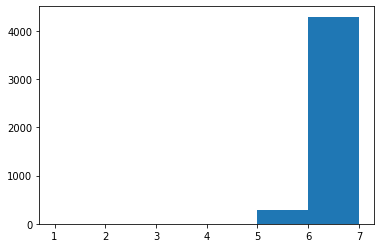

In [91]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [149]:
def plot_sample_no_intersections(G, VV, sample, geom):
    
    V = VV.copy()
    geomet = geom.copy(); N = len(V)
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample[::-1]:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            if C[u] == 0:
                C[u] = i + 1
                
#     newC = list(range(1, len(sample) + 1))
#     random.shuffle(newC)
#     for u in range(N):
#         if C[u] != -1:
#             C[u] = newC[C[u] - 1]

    # Marcamos los elementos visitados en geometry
    geomet['color'] = -1
    for u in range(N):
        if C[u] != -1:
            geomet.loc[geomet['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
#     coord = points_coordinates(sample, geometry, _id)
#     for i in range(len(coord)):
#         geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(sample) - 2]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geomet.plot(ax = ax, column = 'color',
                     figsize=(15, 15),
                     legend = True,
                     legend_kwds={'label': "-1: No considerado \n 0: No cubierto ", 'orientation': "horizontal"},
                     cmap = 'nipy_spectral',)
    plt.show()

In [150]:
def simulate_single_search(G, N, F, s_init, r, geometry):
    
    GR = G.reverse()
    
    E = G.edges()
    
    CV = [0 for u in range(N)]

    CV[r] = 1
    Q = deque([]); Q.append(r)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not CV[v]:
                CV[v] = 1
                Q.append(v)

    V = [0 for u in range(N)]

    s = s_init
    for t in range(100):

        P = []

        mx = 0
        Q = deque([s]); visited = set([s])
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if v not in visited and not V[v]:
                    if F[(u, v)] == mx:
                        P.append(v)
                    if F[(u, v)] > mx:
                        mx = F[(u, v)]
                        P = [v]
                    visited.add(v)
                    Q.append(v)
                    
        print(P)
        plot_sample_no_intersections(GR, V, P, geometry)
        
        for u in P[::-1]:
            if CV[u]:
                I = set(get_ideal(GR, V, u)[::-1])
                V = [not (v in I) for v in range(N)]
                s = u; break
            else:
                V, _ = visit(GR, V, u)

        size = N - sum(V)

        if size == 1:
            print(f"Result {r}: {t + 1}")
            break
        if t == 99:
            print(f"{r}!!!")


Optimal Steps: 10
[2147]


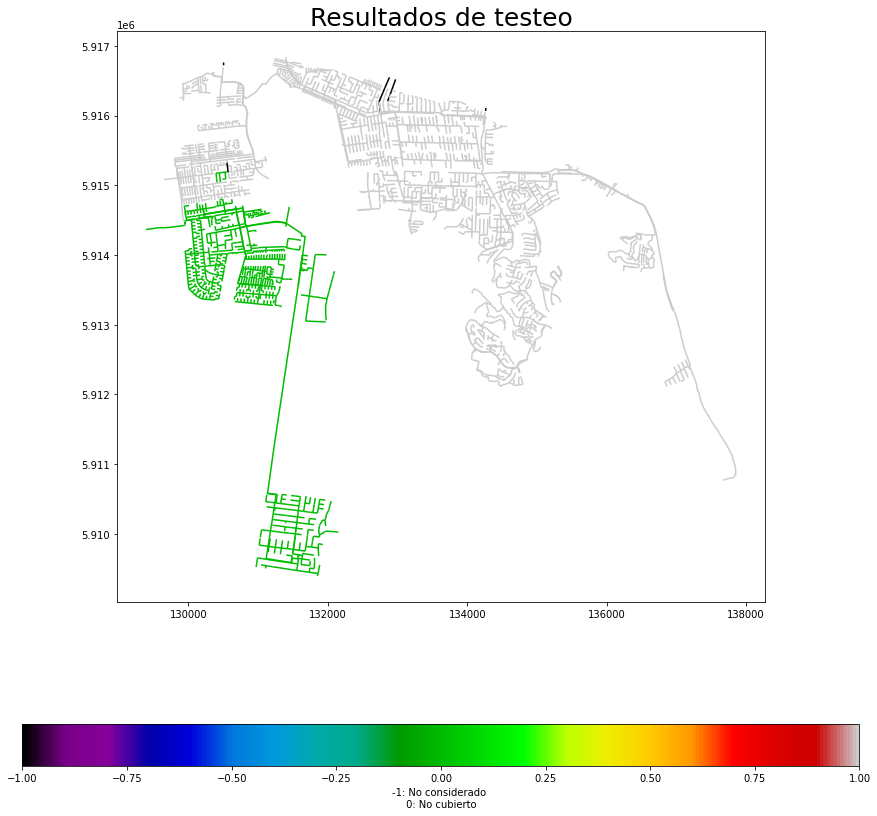

[1432]


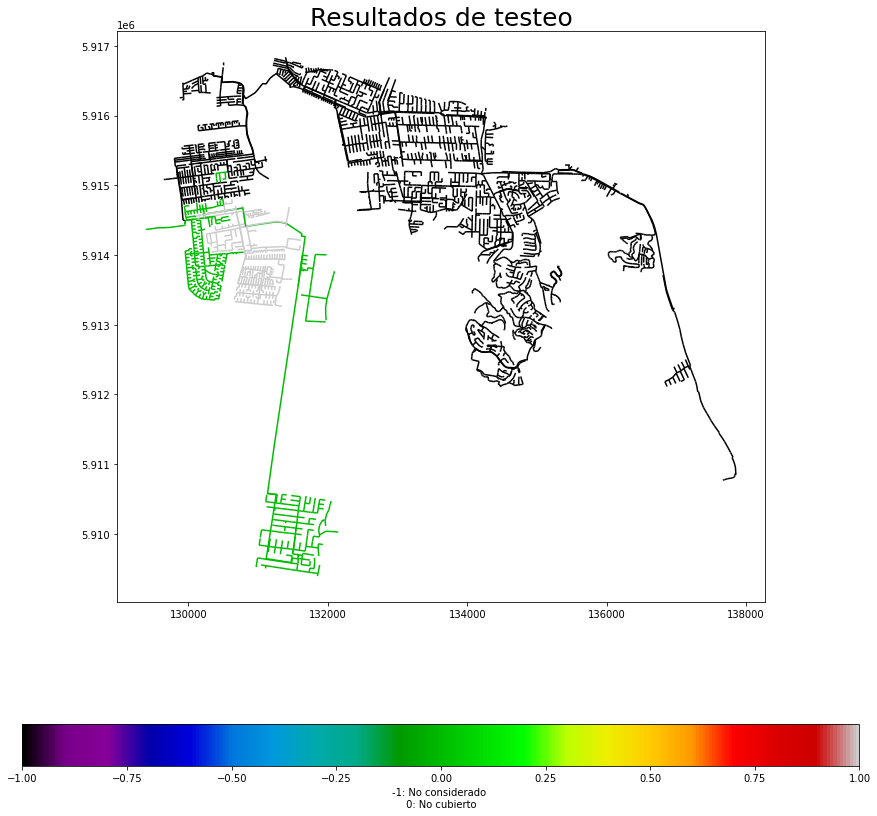

[2318, 422]


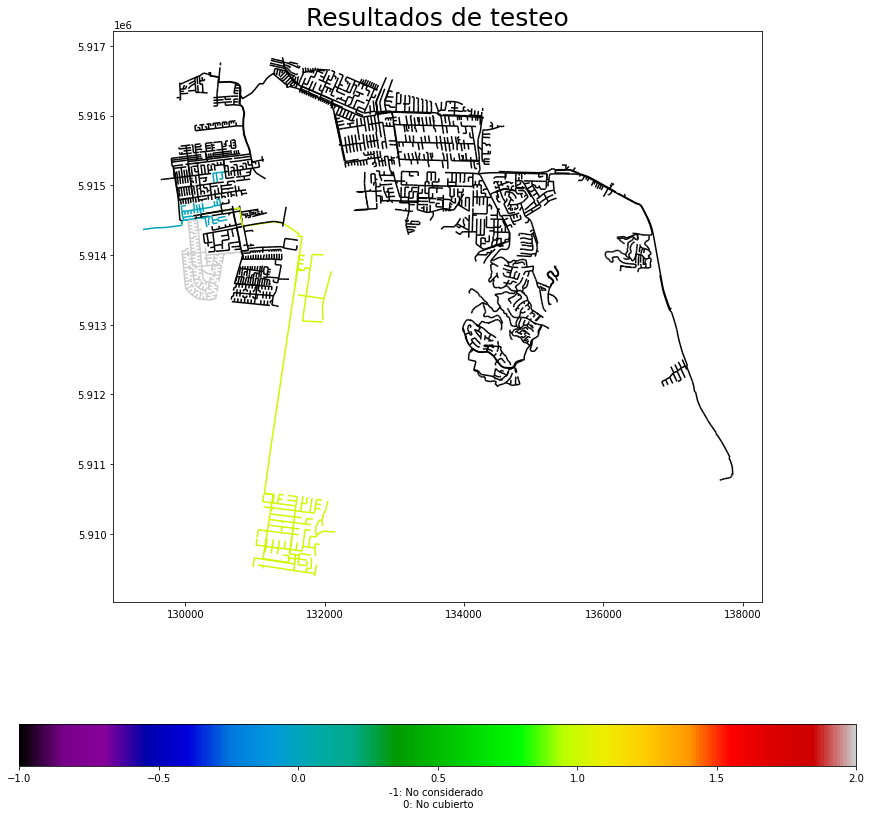

[2027, 1680]


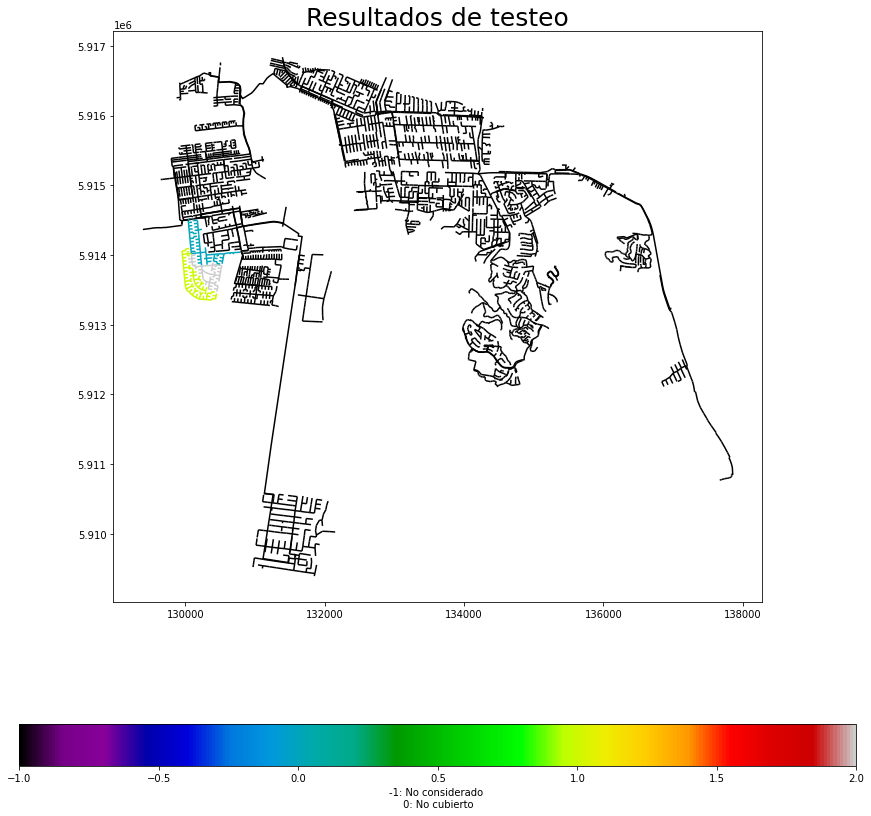

[2007, 1275]


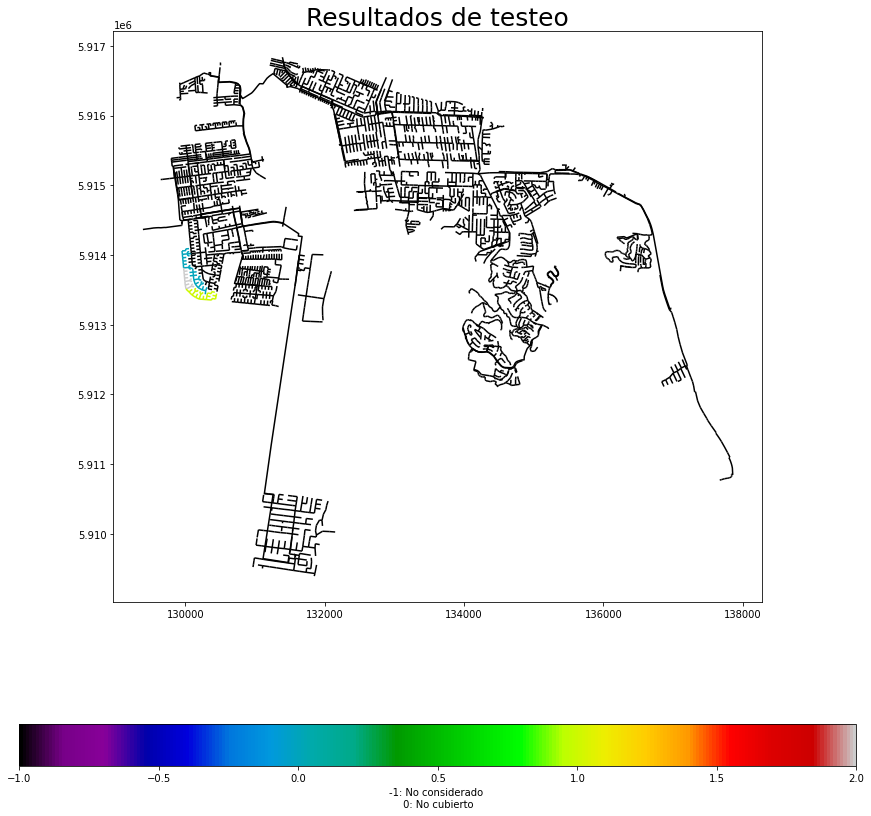

[2008, 2302]


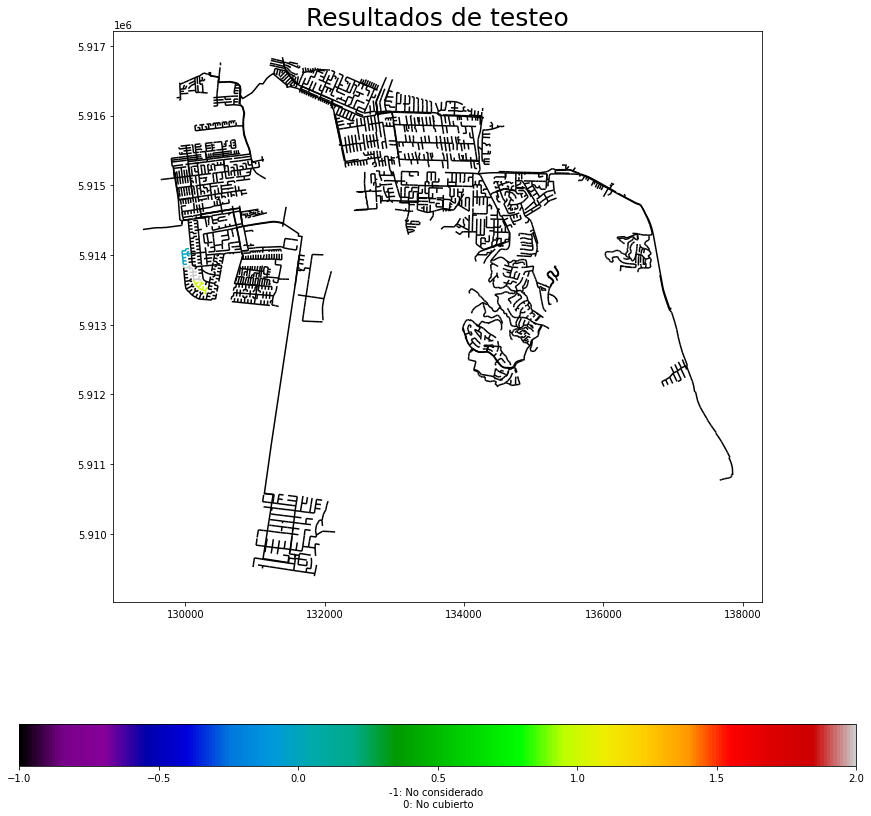

[2004, 2298]


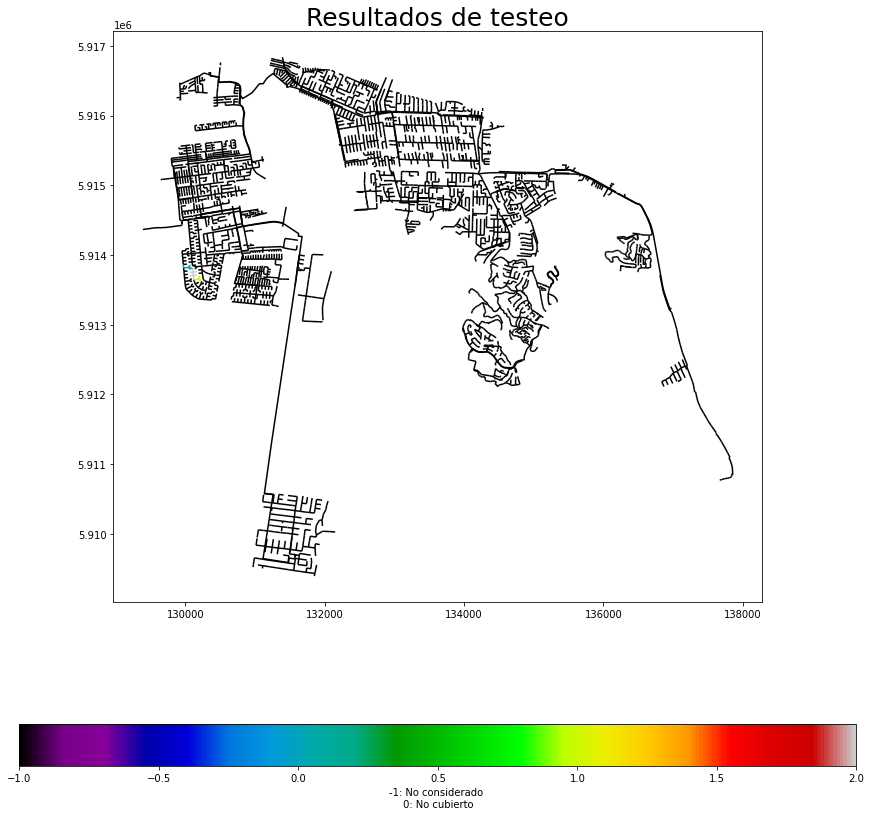

[1675, 1999]


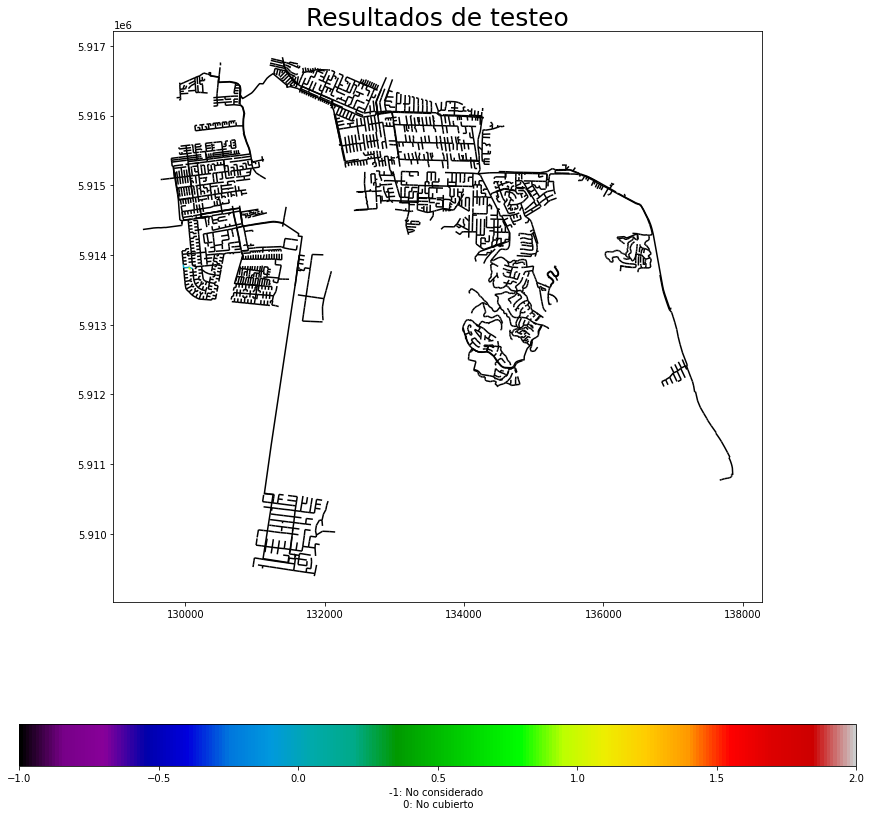

[2000]


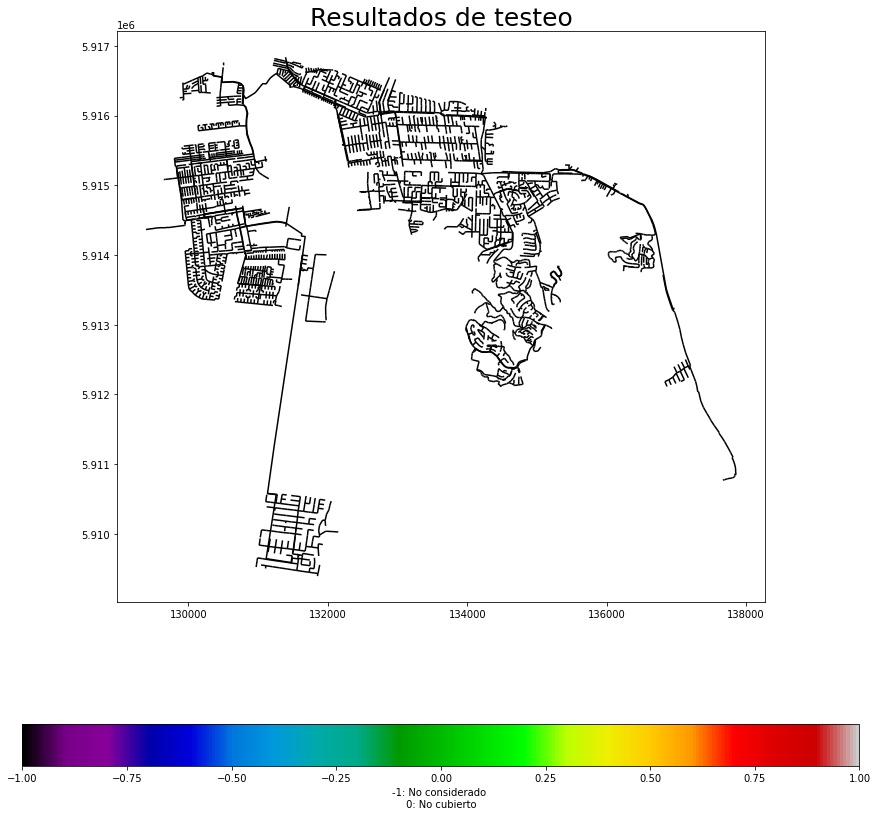

Result 2000: 9


In [152]:
F = get_optimal_K_function(T, 2)
simulate_single_search(T, N, F, 744, 2000, geometry)